In [2]:
import time
import os
import pandas as pd
import numpy as np
import importlib
import mma
import skimage
import matplotlib.pyplot as plt

plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg'

from matplotlib import patches
import matplotlib.animation as anm
from scipy import ndimage as ndi
from scipy import optimize as opt
from scipy import signal

from IPython.display import HTML
from matplotlib.lines import Line2D
import matplotlib.colors as mpl_colors
import seaborn as sns

mpl_named_colors = ['gray', 'g', 'y', 'r', 'k', 'c']

pad_vec=np.arange(6)
ir_pads = np.array([0,1,2])
r_pads = np.array([3,4,5])
skip_pads = np.array([0,3,4])

# skip_pads = np.array([17,18,12,23,1,4,5,2])
columns = ['inducers','skip']
metadata_df = pd.DataFrame(index=pad_vec,columns=columns)
metadata_df.loc[ir_pads,'inducers'] = 'ir'
metadata_df.loc[r_pads,'inducers'] = 'r'
metadata_df.loc[:,'skip'] = False
metadata_df.loc[skip_pads,'skip'] = True

In [6]:
metadata_gb = metadata_df.groupby(['inducers','skip'])
md_keys = list(metadata_gb.groups.keys())
md_key_dict = dict(zip(md_keys, np.arange(len(md_keys))))

columns = ['inducers','skip']
label_df = pd.DataFrame(np.array(md_keys),columns=columns)
def format_label(row):
    inducers, skip = row
    inducers_dict = {'ir':'Active','r':'Inactive'}
    skip_dict = {True:'\nskip',False:''}
    in_list = [inducers, skip]
    dict_list = [inducers_dict,skip_dict]
    zip_obj = zip(in_list, dict_list)
    return ''.join([yy[xx] for xx, yy in zip_obj])
label_df['label'] = [format_label(xx) for xx in md_keys]

metadata_df['mdi'] = -1
for md_key in md_keys:
    sub_df = metadata_gb.get_group(md_key)
    mdi = md_key_dict[md_key]
    metadata_df.loc[sub_df.index,'mdi'] = mdi
metadata_df['label'] = label_df.loc[metadata_df.mdi.values,'label'].values

In [8]:
pad_ind = 1
tiff_fn_tmpl = '/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/{}pad{}.tif'
tiff_fn = tiff_fn_tmpl.format('',pad_ind)
md_dict = mma.WriteHelper._get_tiff_metadata(self=None,tiff_fn=tiff_fn)
bg_option = md_dict['bg_option']
bg_sigma = np.int(md_dict['bg_sigma'])
scale = np.int(md_dict['scale'])
sigma = np.int(md_dict['sigma'])
print(md_dict)

{'bg_option': 'comb', 'bg_sigma': '24', 'channels': '3', 'hyperstack': 'True', 'images': '69', 'mode': 'grayscale', 'scale': '1', 'sigma': '2', 'slices': '23'}


In [9]:
with open('./txt_files/unique_good_dirs_nodatadirs.txt', 'r') as f:
    exp_dirs = f.read().splitlines()
i = 0

In [10]:
mma = importlib.reload(mma)
acq = mma.Acquisition('/groups/murray-biocircuits/jparkin/movies/200613_unordered/img_3/')
# acq.plot_positions()

### Prepare tiff stacks of background-subtracted pad images

In [5]:
thresh_df_fn = os.path.join(acq.super_dir,'csvs','empirical_thresholds.csv')
thresh_df = pd.read_csv(thresh_df_fn, index_col=['type','ci','frame'])

In [6]:
thresh_df.head()

threshold
type ci frame           
arr  0  0       0.000000
        1      46.400757
        2      46.218774
        3      49.382776
        4      42.435345

## Fixing thresholding and bg subtraction


test out different savgol parameters.
it looks like window=3, order=1 looks good

In [5]:
proc = mma.ProcessUnorderedDiff(acq, 1, scale=scale, sigma=sigma, 
                                bg_sigma=bg_sigma, bg_option=bg_option, diff=True)
proc._setup(overwrite=False)

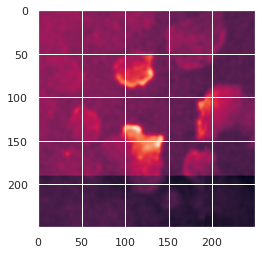

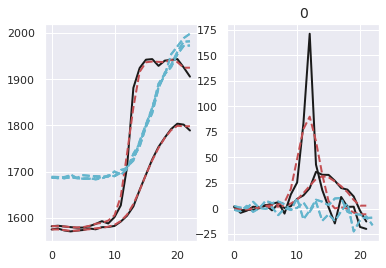

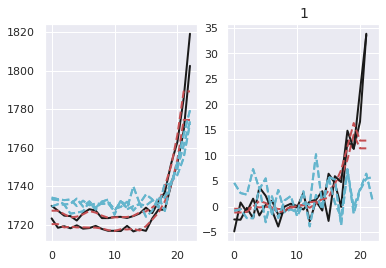

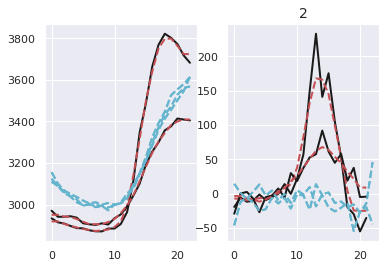

In [116]:
# find bright area and compare pixel traces of arr and filt_arr
arr = proc.pad_helper.load_tiffstack('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/raw_pad1.tif',memmap=True)
bpl_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/rbg.tiff',memmap=True)
plt.imshow(arr[10,2,1550:1800,1550:1800])
bright_pixels = [(1700, 1775), (1650,1700)]
colors = ['c','k']
for ci in [0,1,2]:
    fig, axs = plt.subplots(1,2)
    for pix in bright_pixels:
        yi, xi = pix
        ax = axs[0]
        ax.plot(arr[:,ci,yi,xi],c='k')
        sg_f = lambda x : signal.savgol_filter(x,3,0)
        filt_vec = sg_f(arr[:,ci,yi,xi])
        ax.plot(filt_vec,'--',c='r')
        ax.plot(bpl_arr[:,ci,350,250],'--',c='c')
        ax = axs[1]
        d_filt_vec = np.diff(filt_vec)
        ax.plot(np.diff(arr[:,ci,yi,xi]),c='k')
        ax.plot(sg_f(d_filt_vec),'--',c='r')
        ax.plot(np.diff(bpl_arr[:,ci,350,250]),'--',c='c')
    plt.title(ci)

your background subtractions don't seem to work in later frames. check different raw positions to see if there's a massive difference in background fluorescence that would explain why your background positions don't keep up. yeah it just looks like they don't. so use a known high-background position as your background and try again. in this case, position 81 has part of a weird CFP bubble and is at an inter-colony position with lots of yfp. 

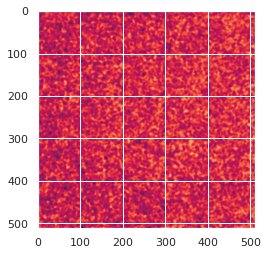

In [142]:
# pos_arr = proc._load_pos_stack(pos)
plt.imshow(pos_arr[11,2,:,:])

In [110]:
proc = mma.ProcessUnorderedDiff(acq, 1, scale=scale, sigma=sigma, 
                                bg_sigma=bg_sigma, bg_option='default')
pos_list = [146, 138, 187, 195, 73,74,75]
stack_list = [proc._load_pos_stack(pos) for pos in pos_list]

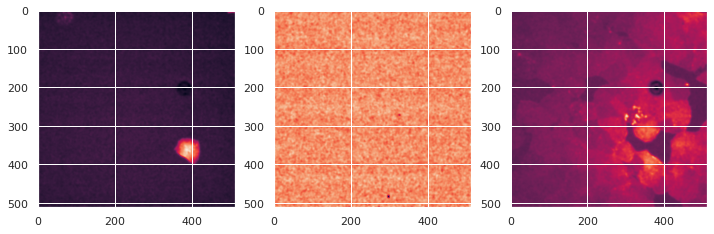

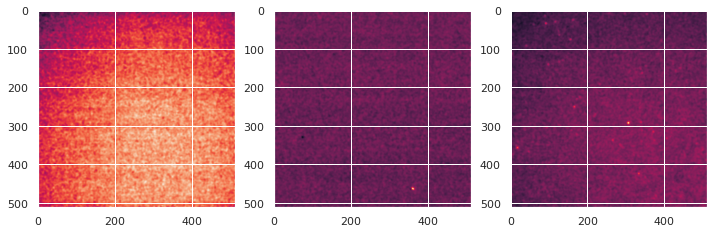

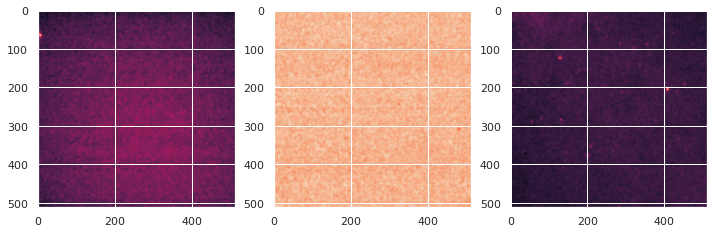

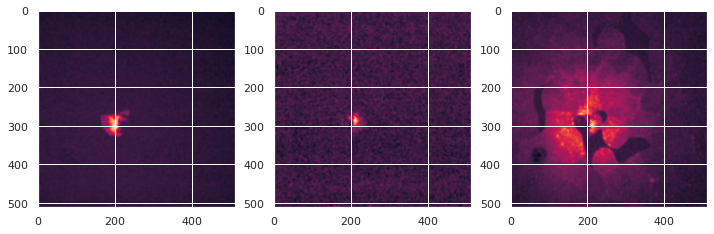

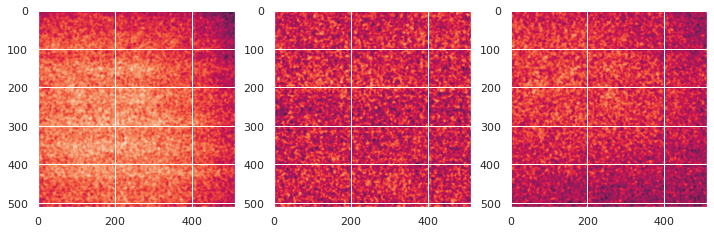

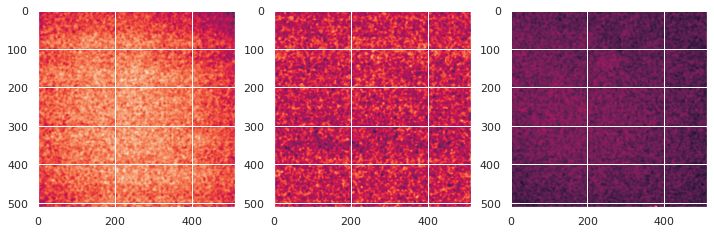

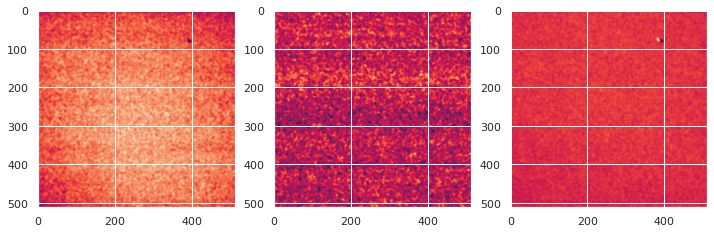

In [111]:
for pos_lab, pos_arr in zip(pos_list, stack_list): 
    fig, axs = plt.subplots(1,3,figsize=(12,5))
    for ci in [0,1,2]:
        axs[ci].imshow(pos_arr[15,ci,:,:]-pos_arr[0,ci,:,:])


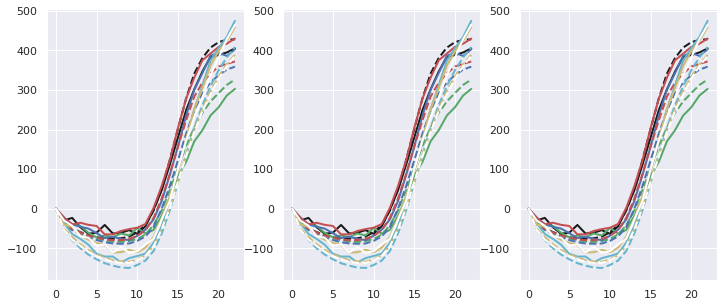

In [112]:
# for pos_lab, pos_arr in zip(pos_list, stack_list): 
#     fig, axs = plt.subplots(1,3,figsize=(12,5))
#     for ci in [0,1,2]:
#         axs[ci].imshow(pos_arr[12,ci,:,:]-pos_arr[0,ci,:,:])

fig, axs = plt.subplots(1,3,figsize=(12,5))
colors = ['k','g','b','r','c','y','w']
for color, pos_lab, pos_arr in zip(colors, pos_list, stack_list):
    sub_arr = pos_arr[:,ci,:,:]-pos_arr[0,ci,:,:]
    quant_vec = np.quantile(sub_arr,q=0.1,axis=[1,2])
    for ci in [0,1,2]:
        diff_vec = sub_arr[:,48:52,48:52].mean(axis=1).mean(axis=1)
        axs[ci].plot(diff_vec,color+'-',ms=3)
        axs[ci].plot(quant_vec[:],color+'--',ms=3)
    
    

you're seeing that later frames have background fluorescence that crosses threshold values. your approach to resolving this will be to see whether that background can be subtracted. if not, you will increase the threshold values, in particular for the derivative arrays. 

#### Thresholds and quantiles

In [119]:
mma = importlib.reload(mma)

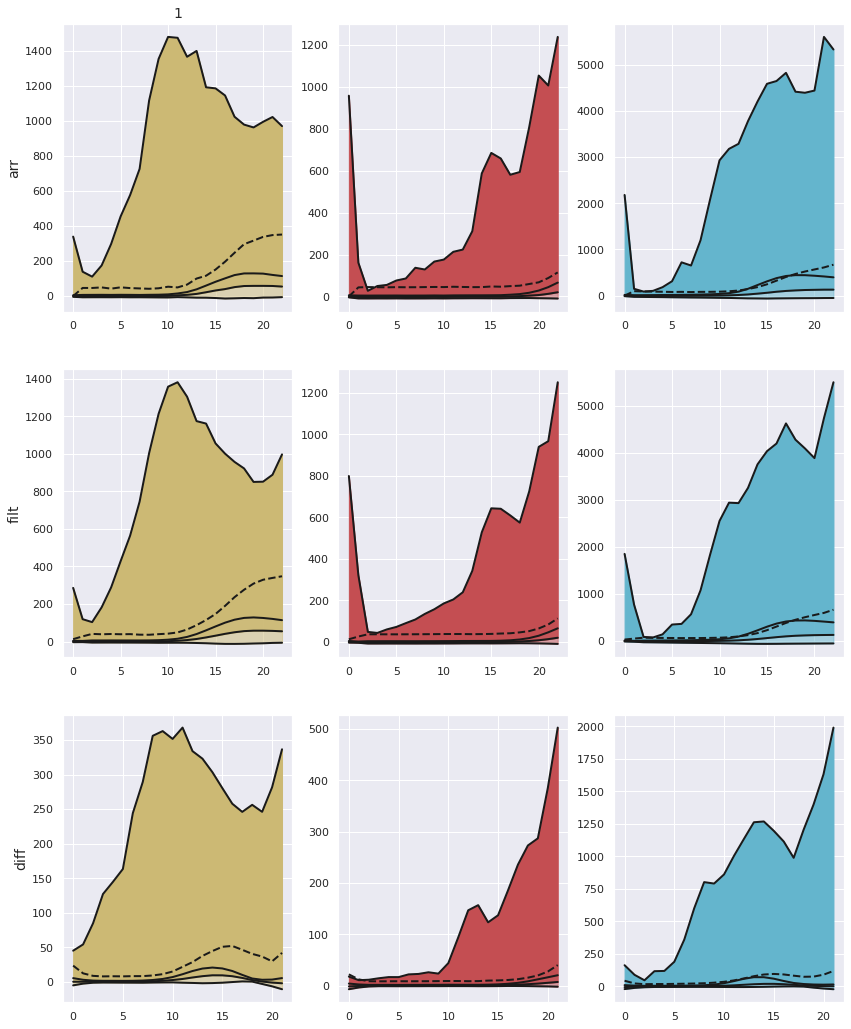

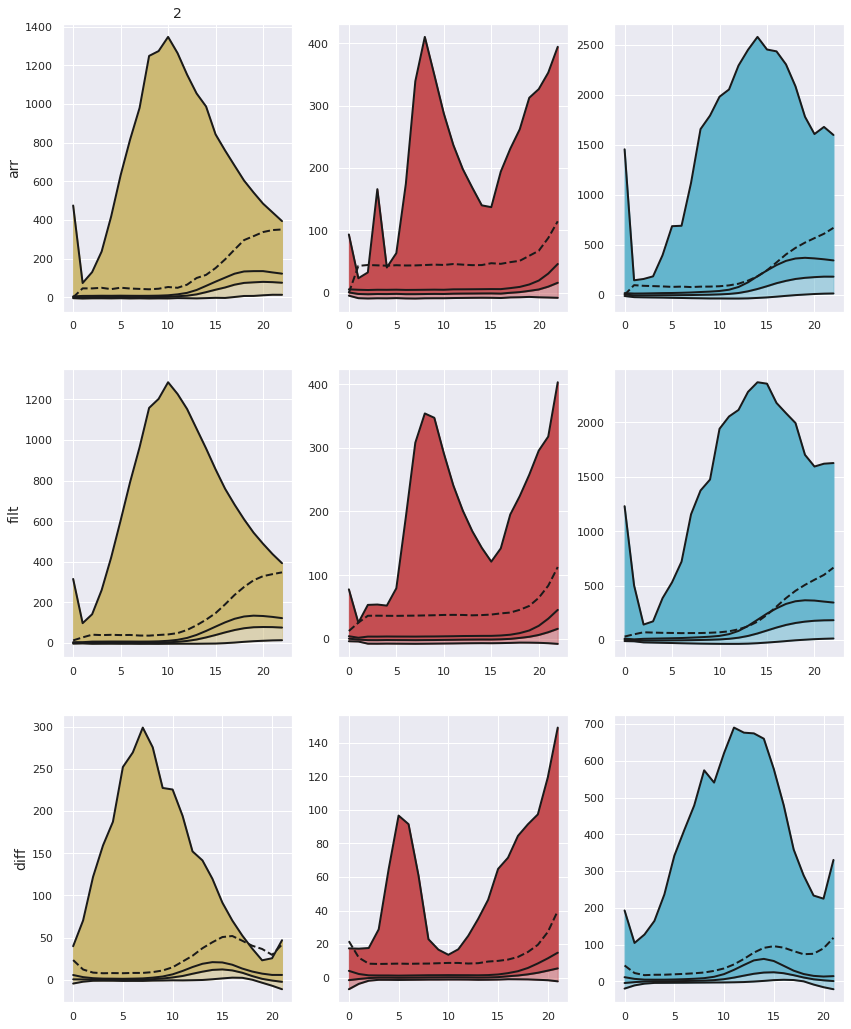

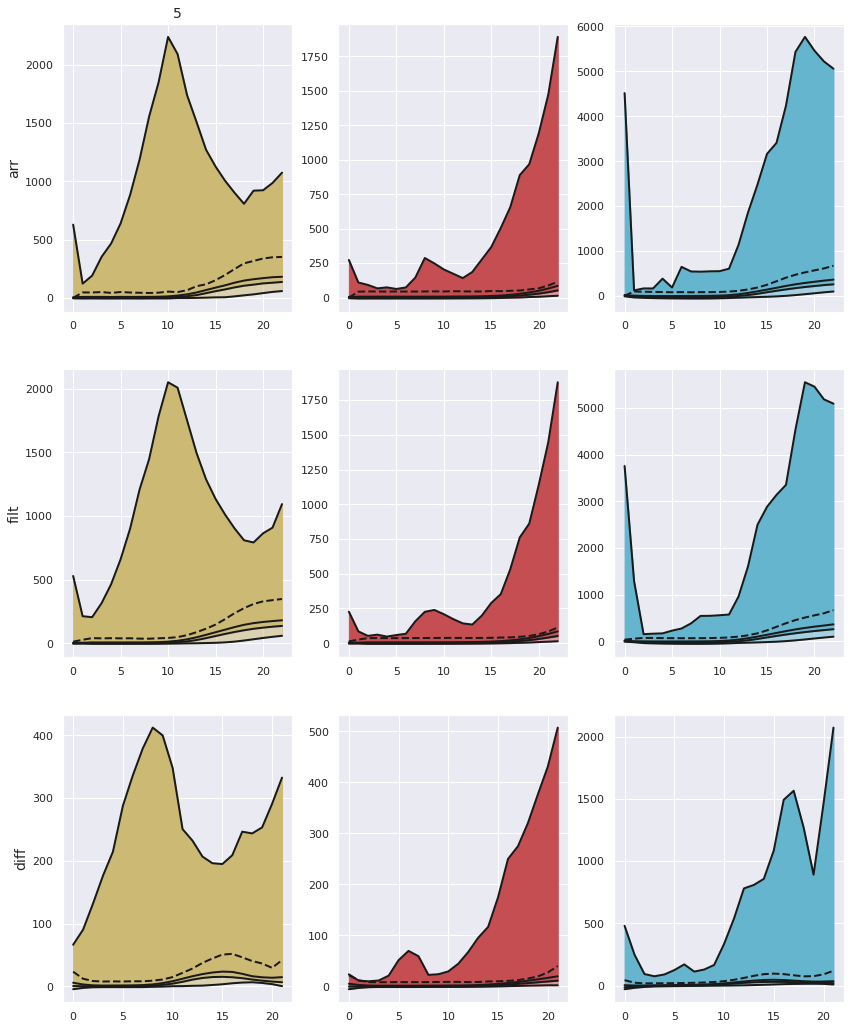

In [124]:
bounds = [0.05,0.5,0.95,1]
# bounds = [0.1,0.3,0.5,0.7,0.9,0.98,1]
mpl_colors_vec = np.array(mma.mpl_named_colors)[acq.chan_ind_list]
ylabs = ['arr', 'filt', 'diff']
for pad in [1,2,5]:
    proc = mma.ProcessUnorderedDiff(acq, pad, scale=scale, sigma=sigma, 
                                    bg_sigma=bg_sigma, print_img=False, bg_option=bg_option)
    proc._setup()
    fig, axs = plt.subplots(3,3,figsize=(14,18))
    arr_list = [proc.arr, proc.filt_arr, proc.diff_arr]
    for i_im, arr in enumerate(arr_list):
        f_vec = np.arange(arr.shape[0])
        for color, ci in zip(mpl_colors_vec, [0,1,2]):
            m_inds = (ylabs[i_im], ci, slice(None))
            thresh_vec = thresh_df.loc[m_inds,'threshold']
            ax = axs[i_im, ci]
            _ = ax.plot(f_vec, thresh_vec, '--k')
            bound_arr = np.zeros((len(bounds), len(f_vec)))
            for f_i in f_vec:
                bound_arr[:,f_i] = np.quantile(arr[f_i, ci,::4,::4].flatten(), q=bounds)    
            _ = ax.plot(f_vec, bound_arr[0,:], c='k')
            for b_i, b_val in enumerate(bounds[1:]):
                _ = ax.plot(f_vec, bound_arr[b_i+1,:], c='k')
                _ = ax.fill_between(f_vec, bound_arr[b_i,:], bound_arr[b_i+1,:], color=color, alpha=b_val)
        axs[i_im,0].set_ylabel(ylabs[i_im])
    axs[0,0].set_title(pad)


## Testing out derivative thresholding

### Correcting for rfp activation in yfp excitation
I believe this is not necessary in this case, as there is not much rfp fluoresence

### Determining growth rate phases by yfp colonies

In [5]:
mma = importlib.reload(mma)
pad_ind = 1

In [125]:
pad_df_fn = os.path.join(acq.super_dir,'csvs','pad{}.csv').format(pad_ind)
pad_df = pd.read_csv(pad_df_fn)

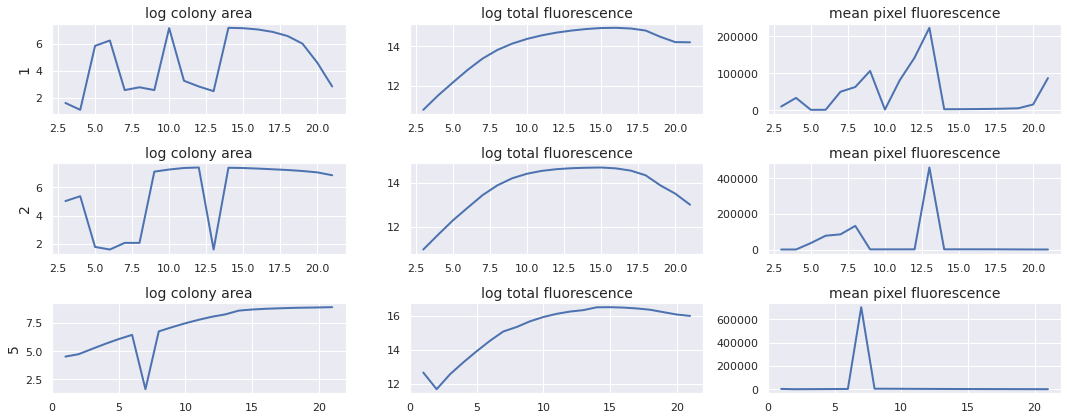

In [26]:
sub_metadf = metadata_df.loc[metadata_df.index>0,:]
sub_metadf = sub_metadf.groupby('skip').get_group(False)
n_pads = sub_metadf.shape[0]
fig, axs = plt.subplots(n_pads,3,figsize=(15,n_pads*2))
for plot_row, pad_ind in enumerate(sub_metadf.index.values):
    procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=scale, sigma=sigma, bg_sigma=bg_sigma, 
                                    print_img=False, bg_option=bg_option,diff=True)
    procdiff._setup(False)
    nf, nc, nh, nw = procdiff.diff_arr.shape
    areas = np.zeros(nf)
    fluors = np.zeros(nf)
    csv_fn = os.path.join(acq.super_dir,'csvs','pad{}.csv'.format(pad_ind))
    pad_df = pd.read_csv(csv_fn)
    thresh_dict = pad_df[['frame','channel','thresh']].groupby(['frame','channel']).agg(np.min)
    for f_i in np.arange(nf):
        yfp_arr = procdiff.filt_arr[f_i,0,:,:]
        key = (f_i, 2)
        if key in thresh_dict.index:
            thresh = thresh_dict.loc[(f_i,2),'thresh']
            bw_im = yfp_arr > thresh
            if np.sum(bw_im)>40:
                masks = skimage.measure.label(bw_im)
                rp = skimage.measure.regionprops(masks, yfp_arr)[0]
                areas[f_i] = rp.area
                fluors[f_i] = np.sum(yfp_arr[yfp_arr>thresh])
    a_vec = areas[areas>1]
    fl_vec = fluors[areas>1]
    f_vec = np.arange(nf)[areas>1]
    axs[plot_row, 0].plot(f_vec,np.log(a_vec))
    axs[plot_row, 0].set_title('log colony area')
    axs[plot_row, 0].set_ylabel(pad_ind)
    axs[plot_row, 1].plot(f_vec,np.log(fl_vec))
    axs[plot_row, 1].set_title('log total fluorescence')
    axs[plot_row, 2].plot(f_vec,fl_vec/a_vec)
    axs[plot_row, 2].set_title('mean pixel fluorescence')
fig.tight_layout()


In [ ]:
bvec = f_all_list < 30
f_sub, fl_sub = f_all_list[bvec]*8*60,np.log(fl_all_list)[bvec]
pfit = np.polyfit(f_sub, fl_sub, 1)
pfn = np.poly1d(pfit)
plt.plot(f_sub, fl_sub,'.')
f_sim = np.arange(35)*8*60
plt.plot(f_sim, pfn(f_sim),'--')
plt.title(pfit)

# See if you can get rid of the cfp channel spots in diff arr

In [9]:
filt_mask = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/pad1_masks.tif')
filt_label = skimage.morphology.label(filt_mask[:,2,:,:])

<Figure size 648x648 with 0 Axes>

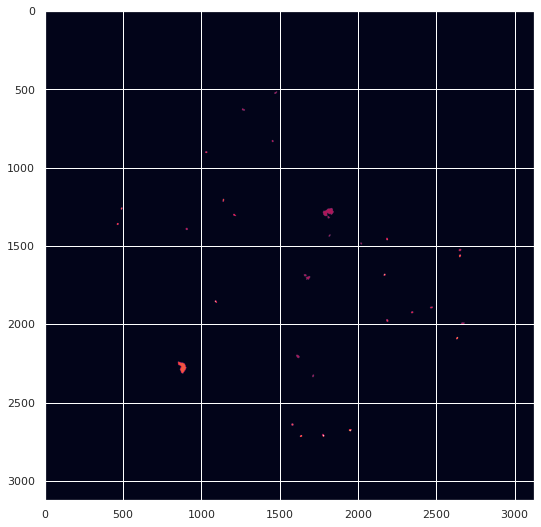

In [25]:
plt.figure(figsize=(9,9))
plt.imshow(filt_label[8,...])

### Testing out new threshold crossing components
* you need to make sure your fancier process_frame_stacks works
* it looks like minsize 100 would perform better
* still need to make sure peak_fitter works

In [31]:
mma = importlib.reload(mma)

In [12]:
lab_df = procdiff._make_lab_df_from_stacks()

In [32]:
pad_ind = 1
procdiff = mma.ProcessUnorderedDiff(acq, pad_ind, scale=scale, sigma=sigma, 
                                bg_sigma=bg_sigma, bg_option=bg_option, diff=True)
procdiff._setup(False)
# df = procdiff.process_frame_stacks(9)

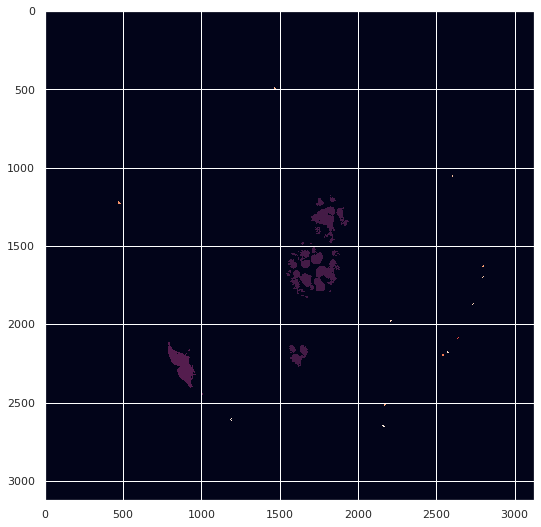

In [33]:
plt.figure(figsize=(9,9))
plt.imshow(procdiff.arr_dict['diffmask'][9,2,:,:],interpolation='none')

In [112]:
rprops = skimage.measure.regionprops(
    skimage.morphology.label(procdiff.diff_mask[7,2,:,:]>0), 
                                     procdiff.diff_arr[7,2,:,:])

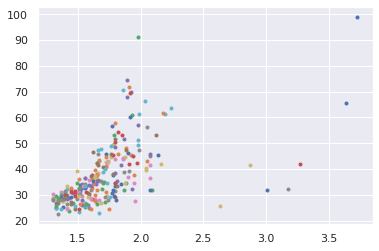

In [113]:
for rprop in rprops:
    plt.plot(np.log10(rprop.area), rprop.mean_intensity, '.')

### check peak fitter
chan_bin_width was set too high. reduced by about 1/5.

you need to manually remove the masks for the large artifacts in pads 2, 5

#### remove masks for artifacts
when begin_stacks() is used, only masked regions are included in processing. removing masks for artifacts removes them from downstream analysis. Every time `_load_masks()` is used, these cells should be ran again but with manually ensuring the label numbers are correct. 

you could automate this process by running regionprops and leaving deleting only masks which centroids inside the hard-coded bounding boxes.

In [237]:
# pad 2 artifacts
# load filt masks
mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad2_masks.tif')


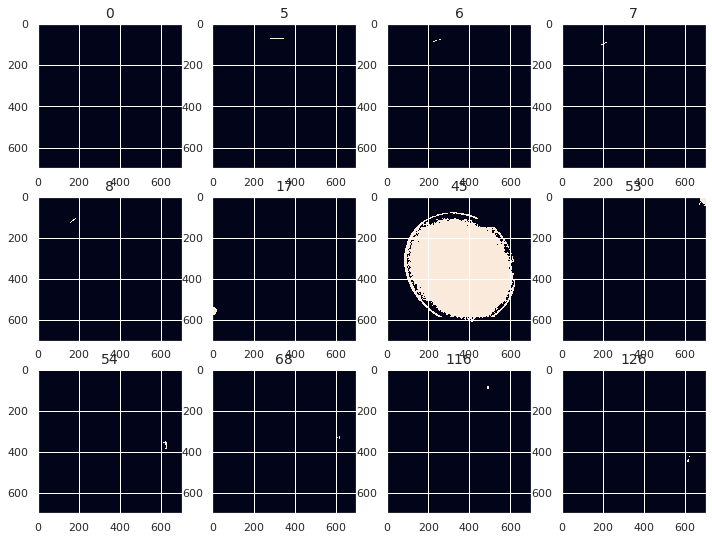

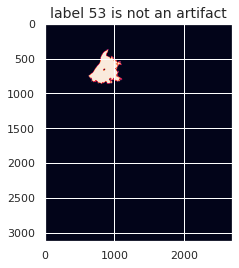

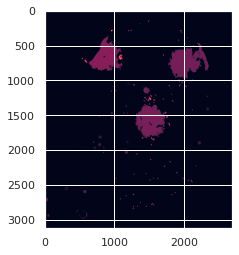

In [240]:
# isolating artifact 1
lab_vec = np.unique(np.max(mask_arr[:,2,800:1500,:700],axis=0))
n_masks = len(lab_vec)
fig_width = int(np.ceil(np.sqrt(n_masks)))
fig_height = int(np.ceil(n_masks/fig_width))
fig, axs = plt.subplots(fig_height, fig_width, figsize=(3*fig_width,3*fig_height))
for lab_i, lab in enumerate(lab_vec):
    ax_i, ax_j = lab_i//fig_dim, np.mod(lab_i, fig_dim)
    ax = axs[ax_i, ax_j]
    ax.imshow(np.max(mask_arr[:,2,800:1500,:700]==lab,axis=0),interpolation='none')
    ax.set_title(lab)

# Check label 53
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:]==53,axis=0))
plt.title('label 53 is not an artifact')
# Label 47 is not an artifact. remove from list and remove labels from mask stack
lab_vec = [xx for xx in lab_vec if xx!=53]
for lab in lab_vec:
    bool_arr = mask_arr==lab
    bool_arr[:,:2,:,:] = 0
    mask_arr[bool_arr] = 0

# Check artifact removal
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))

In [246]:
# save mask back to file
procdiff._save_tiffstack('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad2_masks.tif', mask_arr)

'/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad2_masks.tif'

In [247]:
# pad 2 artifacts
# load diff masks
del mask_arr
mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad2_masks.tif')


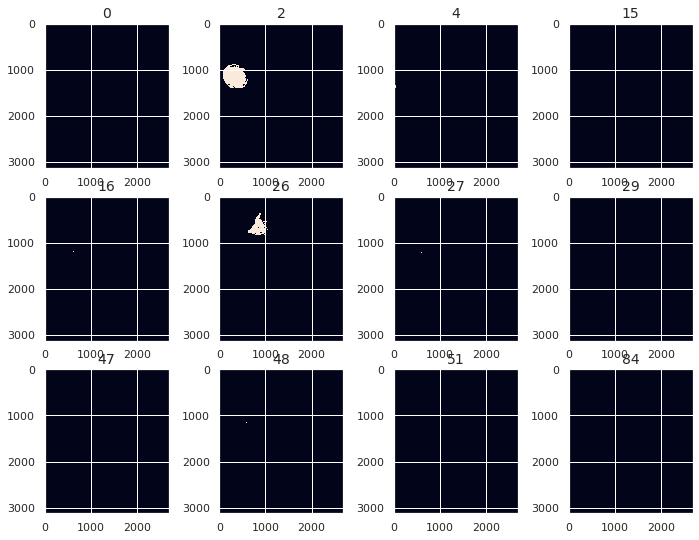

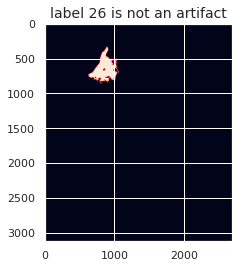

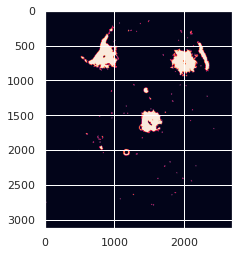

In [251]:
# isolating artifact 1
lab_vec = np.unique(np.max(mask_arr[:,2,800:1500,:700],axis=0))
n_masks = len(lab_vec)
fig_width = int(np.ceil(np.sqrt(n_masks)))
fig_height = int(np.ceil(n_masks/fig_width))
fig, axs = plt.subplots(fig_height, fig_width, figsize=(3*fig_width,3*fig_height))
for lab_i, lab in enumerate(lab_vec):
    ax_i, ax_j = lab_i//fig_dim, np.mod(lab_i, fig_dim)
    ax = axs[ax_i, ax_j]
    ax.imshow(np.max(mask_arr[:,2,...]==lab,axis=0),interpolation='none')
    ax.set_title(lab)

# Mask 26 is not an artifact
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:]==26,axis=0))
plt.title('label 26 is not an artifact')
# Label 26 is not an artifact. remove from list and remove labels from mask stack
lab_vec = [xx for xx in lab_vec if xx!=26]
for lab in lab_vec:
    bool_arr = mask_arr==lab
    bool_arr[:,:2,:,:] = 0
    mask_arr[bool_arr] = 0

# Check artifact removal
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0)>0)

In [252]:
# save mask back to file
procdiff._save_tiffstack('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad2_masks.tif', mask_arr)

'/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad2_masks.tif'

In [253]:
# pad 5 artifacts
# load filt masks
del mask_arr
mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad5_masks.tif')


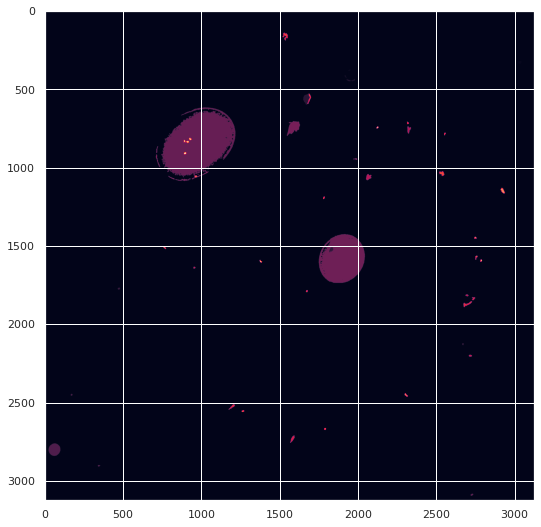

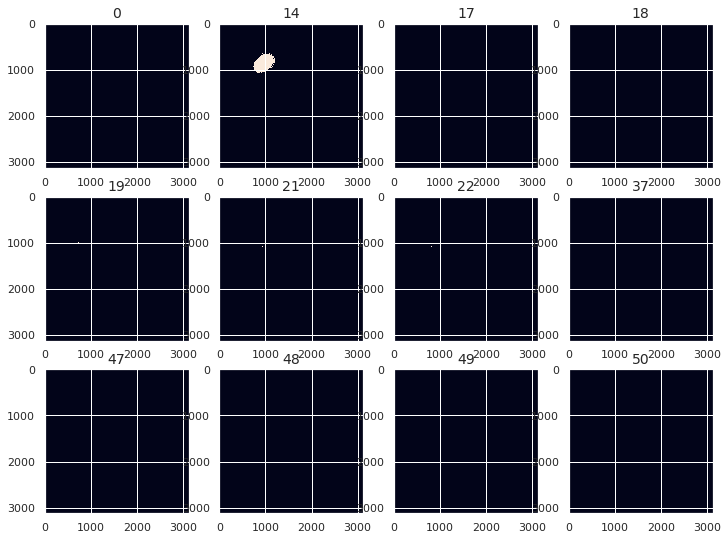

In [255]:
# Find artifacts
plt.figure(figsize=(9,9))
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))

# # isolating artifact 1
lab_vec = np.unique(np.max(mask_arr[:,2,500:1200,700:1300],axis=0))
n_masks = len(lab_vec)
fig_width = int(np.ceil(np.sqrt(n_masks)))
fig_height = int(np.ceil(n_masks/fig_width))
fig, axs = plt.subplots(fig_height, fig_width, figsize=(3*fig_width,3*fig_height))
for lab_i, lab in enumerate(lab_vec):
    ax_i, ax_j = lab_i//fig_dim, np.mod(lab_i, fig_dim)
    ax = axs[ax_i, ax_j]
    ax.imshow(np.max(mask_arr[:,2,...]==lab,axis=0),interpolation='none')
    ax.set_title(lab)

# Looks like all the labels are artifacts
for lab in lab_vec:
    bool_arr = mask_arr==lab
    bool_arr[:,:2,:,:] = 0
    mask_arr[bool_arr] = 0

# # Check artifact removal
# plt.figure()
# plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))

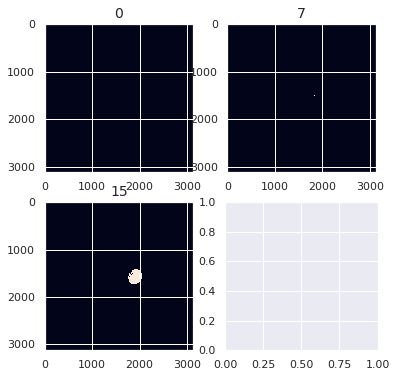

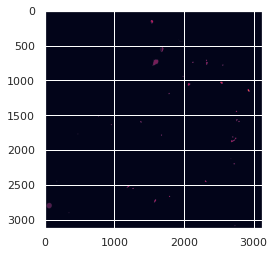

In [256]:
# # isolating artifact 2
lab_vec = np.unique(np.max(mask_arr[:,2,1300:1700,1600:2100],axis=0))
n_masks = len(lab_vec)
fig_width = int(np.ceil(np.sqrt(n_masks)))
fig_height = int(np.ceil(n_masks/fig_width))
fig, axs = plt.subplots(fig_height, fig_width, figsize=(3*fig_width,3*fig_height))
for lab_i, lab in enumerate(lab_vec):
    ax_i, ax_j = lab_i//fig_width, np.mod(lab_i, fig_width)
    ax = axs[ax_i, ax_j]
    ax.imshow(np.max(mask_arr[:,2,...]==lab,axis=0),interpolation='none')
    ax.set_title(lab)

# Looks like all the labels are artifacts
# plt.figure()
# plt.imshow(np.max(mask_arr[:,2,:,:]==25,axis=0))
# plt.title('label 25 is not an artifact')
# Label 25 is not an artifact. remove from list and remove labels from mask stack
# lab_vec = [xx for xx in lab_vec if xx!=25]
for lab in lab_vec:
    bool_arr = mask_arr==lab
    bool_arr[:,:2,:,:] = 0
    mask_arr[bool_arr] = 0

# # Check artifact removal
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))

In [257]:
# save mask back to file
procdiff._save_tiffstack('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad5_masks.tif', mask_arr)

'/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad5_masks.tif'

In [258]:
# pad 2 artifacts
# load diff masks
del mask_arr
mask_arr = skimage.external.tifffile.imread('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad5_masks.tif')


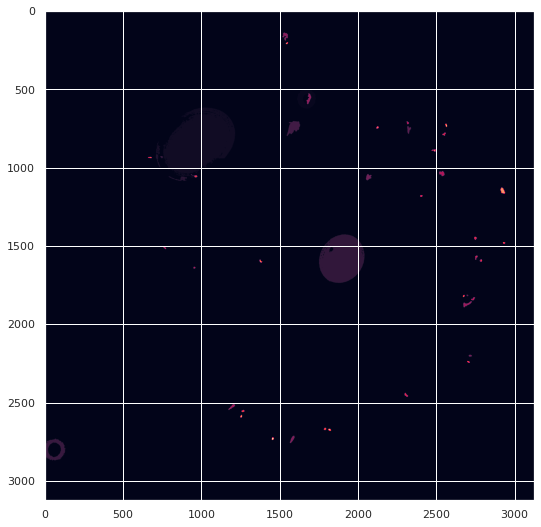

In [259]:
# Find artifacts
plt.figure(figsize=(9,9))
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))


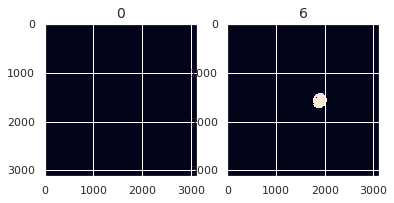

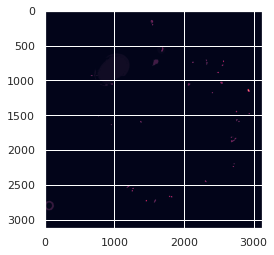

In [260]:
# isolating artifact 1
lab_vec = np.unique(np.max(mask_arr[:,2,1300:1700,1600:2100],axis=0))
n_masks = len(lab_vec)
fig_width = int(np.ceil(np.sqrt(n_masks)))
fig_height = int(np.ceil(n_masks/fig_width))
fig, axs = plt.subplots(fig_height, fig_width, figsize=(3*fig_width,3*fig_height))
for lab_i, lab in enumerate(lab_vec):
    ax_i, ax_j = lab_i//fig_width, np.mod(lab_i, fig_width)
    ax = axs[ax_j]
    ax.imshow(np.max(mask_arr[:,2,...]==lab,axis=0),interpolation='none')
    ax.set_title(lab)

# All labels are artifacts
for lab in lab_vec:
    bool_arr = mask_arr==lab
    bool_arr[:,:2,:,:] = 0
    mask_arr[bool_arr] = 0

# Check artifact removal
plt.figure()
plt.imshow(np.max(mask_arr[:,2,:,:],axis=0))

In [261]:
# save mask back to file
procdiff._save_tiffstack('/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad5_masks.tif', mask_arr)

'/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/diff_pad5_masks.tif'

#### make sure peak fitting works
it seems like your microcolonies are not so spread out as they were in other small-scale experiments. as a result, there were no peaks in the aggragated df produced from microcolonies growing into neighboring distance bins, making peak finding unnecessary. 

In [46]:
pad_ind = 2
chan = 5
csvs_dir = os.path.join(acq.super_dir, 'csvs')
pad_df_fn = os.path.join(csvs_dir, 'pad{}.csv'.format(pad_ind))
pad_df = pd.read_csv(pad_df_fn)

fitter = mma.FrontFitter(acq, diff=True, chan_bin_widths=[400,100,500])

# bin distances
bin_width = acq.pixel_size
d_vec = pad_df.dist.values
pad_df['dist_binned'] = (d_vec//bin_width)*bin_width + (bin_width/2)
inds = [(int(frame), pad_ind) for frame in pad_df.frame.values]
t_vec = fitter.time_df.loc[inds,'time'].values
pad_df['time'] = t_vec
gb_chan = pad_df.groupby('channel')
chan_df = gb_chan.get_group(chan)


In [47]:
gb_cols = ['fluor','frame','dist_binned']
fluor_gb_frame_db = chan_df[gb_cols].groupby(gb_cols[1:])
q_lamb = lambda x : np.quantile(x, 0.95)
agg_df = fluor_gb_frame_db.agg(q_lamb).reset_index()
piv_df = agg_df.pivot(index='dist_binned',values='fluor',columns='frame')

In [48]:
out_list = []
chan_bin = fitter.chan_bin_dict[chan]
n_bins = (agg_df.fluor.max()-agg_df.fluor.min())//chan_bin
thresh_vec = agg_df.fluor.min() + np.arange(n_bins)*chan_bin
for label, thresh in enumerate(thresh_vec):
    bool_vec = agg_df.fluor >= thresh
    sub_df = agg_df.loc[bool_vec, gb_cols].groupby(gb_cols[-1]).agg(np.min).reset_index()
    d_vec, frame_vec = sub_df.dist_binned.values, sub_df.frame.values
#     peaks = mma.signal.find_peaks(-1*frame_vec)[0]
    sub_df['level'] = label
    sub_df['thresh'] = thresh
    out_list.append(sub_df)#.loc[peaks,:])
peaks_df = pd.concat(out_list, ignore_index=True)

In [49]:
label, thresh = 1, thresh_vec[1]
bool_vec = agg_df.fluor >= thresh
sub_df = agg_df.loc[bool_vec, gb_cols].groupby(gb_cols[-1]).agg(np.min).reset_index()
d_vec, frame_vec = sub_df.dist_binned.values, sub_df.frame.values
peaks = mma.signal.find_peaks(-1*frame_vec)[0]
sub_df['level'] = label
sub_df['thresh'] = thresh
out_list.append(sub_df.loc[peaks,:])

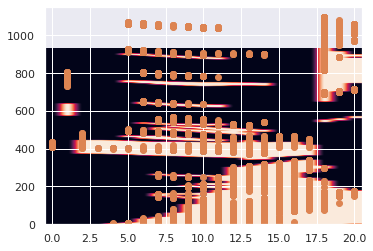

In [50]:
plt.imshow(piv_df.values>thresh,aspect=1/80,origin='lower')
plt.plot(frame_vec-piv_df.columns.min(), d_vec/bin_width,'o')
plt.plot(peaks_df.frame-piv_df.columns.min(), peaks_df.dist_binned/bin_width,'o')

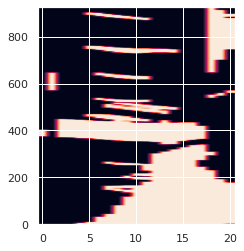

In [51]:
plt.imshow(piv_df.values>0,aspect=1/40,origin='lower')

### make sure mask labeling works
you saw an error in the loop applying the labeling. this affects only the cfp channel. re-write all the mask files.

In [12]:
out_dir = os.path.join(acq.super_dir, 'csvs')


3


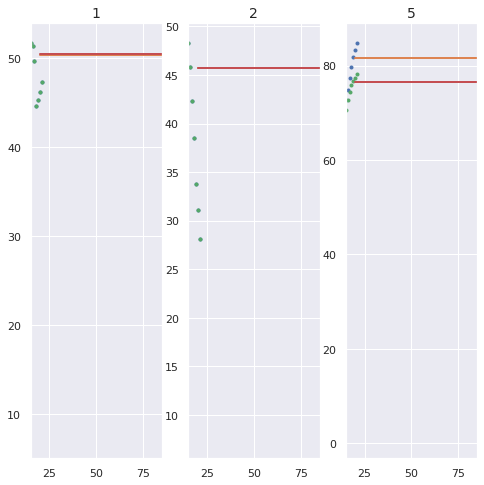

In [15]:
pad_ind_list = [1,2,5]
# pad_ind_list = np.sort(np.array(pad_ind_list))
print(len(pad_ind_list))
fig, axs = plt.subplots(1,len(pad_ind_list),figsize=(8,8))
df_list = []
for prefix, diff in [('diff_', True), ('',False)]:
    for i, pad_ind in enumerate(pad_ind_list):
        ax = axs[i]
        fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format(prefix,pad_ind))
        pad_df = pd.read_csv(fn_tmpl)
        pad_df['diff'] = diff
#         df_list.append(pad_df)
        sub_df = pad_df.loc[(pad_df.rad>0)&(pad_df.channel==5),:].groupby('frame').agg(np.max).reset_index()
        max_col = sub_df.rad.quantile(0.9)
        ax.plot((sub_df.frame), sub_df.rad,'.')
        ax.plot([20,90], [max_col, max_col],'-')
        ax.set_title(pad_ind)
        ax.set_xlim([15,85])
# cross_df = pd.concat(df_list)    

## Trying to find out the best approach for a "recruitment" metric
Start with trying to find the final occupancy of the pad. do this by summing or taking max over each mask stack.
it looks like you can do so through the cfp channel, which has very high cell autofluorescence late in the experiment. due to the blurred nature of the autofluorescence, you'll have to try some edge detection.

trying out approach designed for 200626

In [18]:
thresh_df.head()

,type,ci,frame,threshold
0,arr,0,0,0.000000
1,arr,0,1,42.928583
2,arr,0,2,43.394885
3,arr,0,3,41.895502
4,arr,0,4,43.429797


In [22]:
def calc_recru_frame(frame, mask_chan, filt_arr, mask_arr, thresh_df):
    chan=2
    img_arr = filt_arr[frame,chan,:,:].copy()
    img_mask = mask_arr[frame,mask_chan,:,:]>0
    max_val = thresh_df.loc[('arr',chan,frame),'threshold']
    img_arr[img_arr>max_val] = max_val
    thresh = skimage.filters.threshold_otsu(img_arr)
    img_thresh = img_arr>thresh
#     img_thresh = (img_arr + img_mask)>0
#     if thresh < max_val/9:
#         thresh = max_val
    cell_area = np.sum(img_thresh)*(acq.pixel_size**2)/1e6
    masked_area = np.sum(img_mask)*(acq.pixel_size**2)/1e6
    sender_area = np.sum(mask_arr[frame,0,:,:]>0)*(acq.pixel_size**2)/1e6
    return np.array([masked_area, cell_area])

def calc_recru_pad(acq, pad_ind, mask_chan, proc_args=None):
    fn = '/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad{}.tif'
    filt_arr = skimage.external.tifffile.imread(fn.format(pad_ind),memmap=True)
    fn = '/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad{}_masks.tif'
    mask_arr = skimage.external.tifffile.imread(fn.format(pad_ind),memmap=True)
    fn = os.path.join(acq.super_dir,'csvs','empirical_thresholds.csv')
    thresh_df = pd.read_csv(fn).set_index(['type','ci','frame'])
    recru_arr = np.array([calc_recru_frame(xx, mask_chan, filt_arr, mask_arr, thresh_df) for xx in acq.frame_vec])
    cols = ['pad','mask_chan','frame','masked_area','cell_area']
    pad_vec, mc_vec = np.ones(recru_arr.shape[0])*pad_ind, np.ones(recru_arr.shape[0])*mask_chan
    d_vecs = [pad_vec, mc_vec, acq.frame_vec, recru_arr[:,0], recru_arr[:,1]]
    out_df = pd.DataFrame(dict(zip(cols,d_vecs)))
    return out_df


recru_df = [calc_recru_pad(acq, xx, yy) for xx in [1,2,5] for yy in [1,2]]
recru_df = pd.concat(recru_df, ignore_index=True)

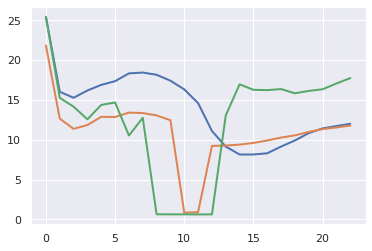

In [30]:
recru_df
for pad in [1,2,5]:
    sub_recru = recru_df.loc[recru_df['pad']==pad,:].sort_values(by='frame')
    plt.plot(sub_recru['frame'],sub_recru['cell_area'])

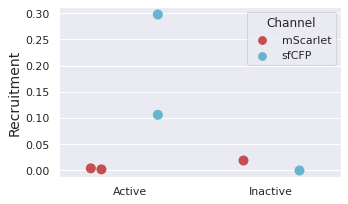

In [106]:
b_vec = (recru_df.frame>12)
sub_recru_df = recru_df.loc[b_vec,:]
b_vec = (metadata_df['skip']==False)
keep_pads = metadata_df.index.values[b_vec]
lam = lambda x : x in keep_pads
b_vec = sub_recru_df['pad'].apply(lam)
sub_recru_df = sub_recru_df.loc[b_vec,:].copy()

# sub_recru_df = recru_df.copy()

plot_labs = ['Active','Inactive']
mdi_vec = [label_df.index.values[label_df.label==xx][0] for xx in plot_labs]

lam = lambda x : metadata_df.loc[x,'mdi']
sub_recru_df['mdi'] = sub_recru_df['pad'].apply(lam)

lam = lambda x : x in mdi_vec
sub_recru_df = sub_recru_df.loc[sub_recru_df.mdi.apply(lam),:].copy()

# keep_pads = metadata_df.index.values[(metadata_df.sender_present)&(metadata_df.skip==False)]
# lam = lambda x : x in keep_pads
# sub_recru_df = sub_recru_df.loc[sub_recru_df['pad'].apply(lam),:].copy()

lam = lambda x : label_df.loc[x,'label']
sub_recru_df['Condition'] = sub_recru_df.mdi.apply(lam)

mdi_x = np.arange(len(mdi_vec))
x_dict = dict(zip(mdi_vec,mdi_x))
x_labs = label_df.loc[mdi_vec,'label']

lam = lambda x : x_dict[x]
sub_recru_df['x'] = sub_recru_df.mdi.apply(lam)

conv_channel = lambda x : dict(zip([1.0,2.0],['mScarlet','sfCFP']))[x]
sub_recru_df['Channel'] = sub_recru_df.mask_chan.apply(conv_channel)

cmap = dict(zip(mma.all_channel_names, mma.mpl_named_colors))

sub_recru_df['Recruitment'] = sub_recru_df.masked_area / sub_recru_df.cell_area

keep_inds = []
recru_gb = sub_recru_df.groupby(['pad','mask_chan'])
for key, sub_df in recru_gb:
    max_recru = sub_df.Recruitment.max()
    keep_inds.append(sub_df.index.values[sub_df.Recruitment==max_recru][0])
plot_df = sub_recru_df.loc[keep_inds,:].copy()

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax = sns.swarmplot(data=plot_df, x='x',y='Recruitment',hue='Channel', 
                   ax=ax,size=10,palette=cmap,dodge=True)
ax.set_xticklabels(x_labs)
ax.set_xlabel('')
fig.tight_layout()
fig_tmpl = 'recruitment_200627.{}'
fig_tmpl = os.path.join(acq.super_dir,'figs',fig_tmpl)
for enc in ['png','pdf']:
    fig.savefig(fig_tmpl.format(enc))

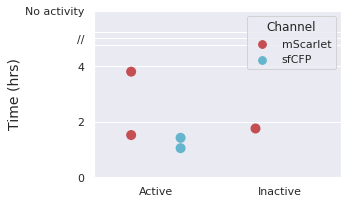

In [107]:
b_vec = (peaks_df.channel>2)&(peaks_df['diff'])#&(peaks_df.dist_binned<200)
sub_peaks_df = peaks_df.loc[b_vec,:]
peaks_gb = sub_peaks_df[['pad','channel','time','mdi']].groupby(['pad','channel'])
agg_min_peaks = peaks_gb.agg(np.min).reset_index()

mdi_x = np.arange(len(mdi_vec))
x_dict = dict(zip(mdi_vec,mdi_x))
x_labs = label_df.loc[mdi_vec,'label']

lam = lambda x : x in mdi_vec
sub_agg = agg_min_peaks.loc[agg_min_peaks.mdi.apply(lam),:].copy()

sub_agg['time_hrs'] = sub_agg.time / 3600
# Add rows with large times where mdi's are missing
gb_tries = sub_agg.groupby(['mdi','channel'])
keys_list = [(xx,yy) for xx in mdi_vec for yy in [3.0,5.0]]
for key in keys_list:
    if not (key in gb_tries.groups.keys()):
        mdi, mask_chan = key
        d_vec = [mdi, mask_chan, 12]
        c_vec = ['mdi','channel','time_hrs']
        new_row = pd.DataFrame(dict(zip(c_vec,d_vec)),index=[0])
        sub_agg = sub_agg.append(new_row, ignore_index=True)

lam = lambda x : label_df.loc[x,'label']
sub_agg['Condition'] = sub_agg.mdi.apply(lam)

lam = lambda x : x_dict[x]
sub_agg['x'] = sub_agg.mdi.apply(lam)

conv_channel = lambda x : dict(zip([3.0,5.0],['mScarlet','sfCFP']))[x]
sub_agg['Channel'] = sub_agg.channel.apply(conv_channel)

sub_agg = sub_agg.drop(sub_agg.index[(sub_agg['pad']==5)&(sub_agg['channel']==5)])

cmap = dict(zip(mma.all_channel_names, mma.mpl_named_colors))

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax = sns.swarmplot(data=sub_agg, x='x',y='time_hrs',hue='Channel', ax=ax,
                   size=10,palette=cmap,dodge=True)
yticks = [0,2,4,4.75,5,5.25,6]
yticklabels = ['{}'.format(xx) for xx in yticks]
yticklabels[-1] = 'No activity'
yticklabels[-2] = ''
yticklabels[-3] = '//'
yticklabels[-4] = ''
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xticklabels(x_labs)
ax.set_ylabel('Time (hrs)')
ax.set_xlabel('')
fig.tight_layout()
fig_tmpl = 'initiation_time_200627.{}'
fig_tmpl = os.path.join(acq.super_dir,'figs',fig_tmpl)
for enc in ['png','pdf']:
    fig.savefig(fig_tmpl.format(enc))

leftover attempts specific to this experiment

In [5]:
# Try to determine space occupied by cells
# check out pad 1 filt_arr
fn = '/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad1.tif'
filt_arr = skimage.external.tifffile.imread(fn,memmap=True)
fn = '/central/scratchio/jparkin/tiffstacks/200613_unordered/img_3/filt_pad1_masks.tif'
mask_arr = skimage.external.tifffile.imread(fn,memmap=True)

cell area is roughly 11.757mm^2
activated cell area is roughly 1.128mm^2
cell recruitment is roughly 0.096%


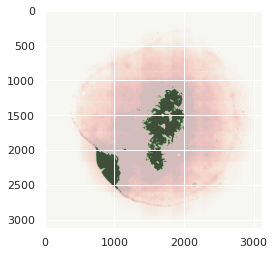

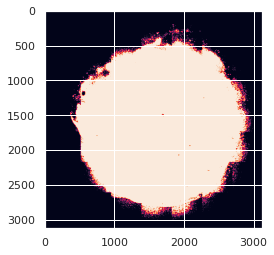

In [138]:
plt.imshow(filt_arr[18,2,:,:],vmin=80,vmax=300,alpha=0.6,cmap='Reds')
plt.imshow(mask_arr[18,2,:,:]>0,alpha=0.6,cmap='Greens')
plt.figure()
thresh = 120
plt.imshow(filt_arr[18,2,:,:]>thresh)
cell_area = np.sum(fill_arr)*(acq.pixel_size**2)/1e6
print('cell area is roughly {:0.3f}mm^2'.format(cell_area))
masked_area = np.sum(mask_arr[18,2,:,:]>0)*(acq.pixel_size**2)/1e6
sender_area = np.sum(mask_arr[18,0,:,:]>0)*(acq.pixel_size**2)/1e6
print('activated cell area is roughly {:0.3f}mm^2'.format(masked_area))
print('cell recruitment is roughly {:0.3f}%'.format((masked_area)/(cell_area-sender_area)))

In [127]:
img_arr = filt_arr[21,2,:,:].copy()
blur_arr = skimage.filters.gaussian(img_arr, 28)
img_filt = skimage.filters.sobel(blur_arr)
edge_arr = img_filt>0.6
edge_arr = skimage.morphology.remove_small_objects(edge_arr, 800)

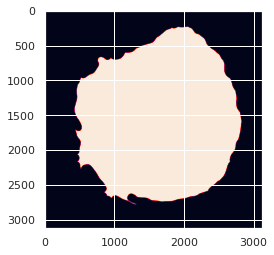

In [135]:
edge_arr = img_filt>0.7
edge_arr = skimage.morphology.remove_small_objects(edge_arr, 20000)
fill_arr = skimage.morphology.flood_fill(edge_arr, (700,1700),1)
fill_arr = skimage.morphology.remove_small_holes(fill_arr, 200000)
selem = skimage.morphology.disk(32)
fill_arr = skimage.morphology.erosion(fill_arr, selem)
plt.imshow(fill_arr)

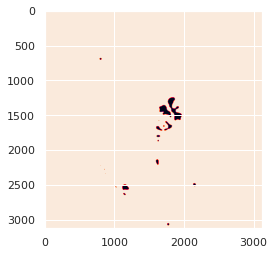

In [118]:
selem = skimage.morphology.disk(1)
fil_arr = skimage.morphology.flood_fill(edge_arr.astype(np.float), (500,2000), 1, selem=selem)
plt.imshow(fil_arr)

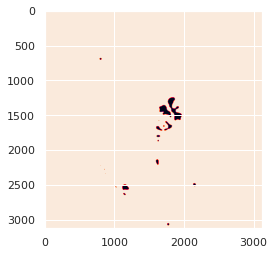

In [99]:
plt.imshow(fil_arr)

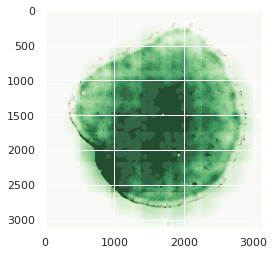

In [9]:
plt.imshow(dil_arr,cmap='Reds',alpha=0.5)
plt.imshow(img_arr,vmin=80,vmax=300,cmap='Greens',alpha=0.8)
# plt.figure()
# plt.imshow(flood_arr,interpolation='none')

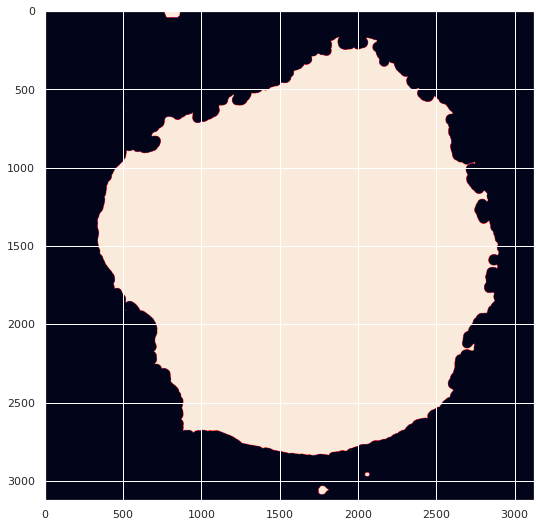

In [73]:
dil_arr[2000:,200:600] = 0
fil_arr = skimage.morphology.remove_small_holes(dil_arr, 800*800)
ero_arr = skimage.morphology.erosion(fil_arr, selem)
selem = skimage.morphology.disk(32)
fin_arr = skimage.morphology.binary_closing(ero_arr,selem)
plt.figure(figsize=(9,9))
plt.imshow(fin_arr)

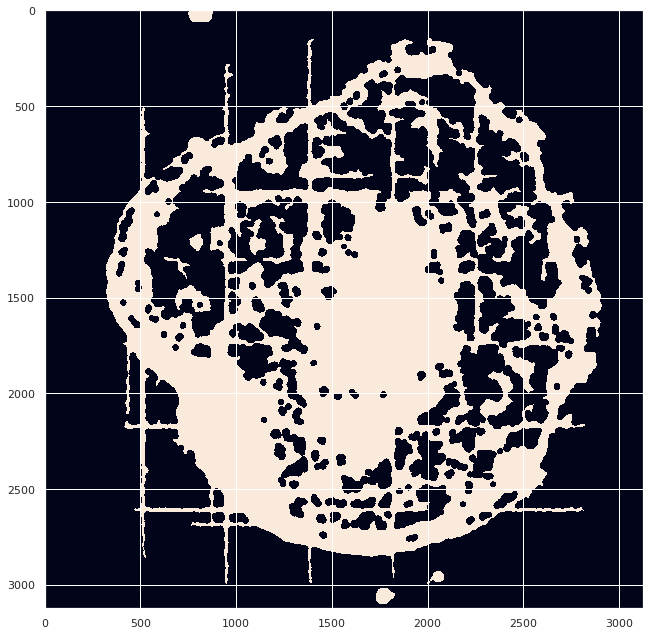

In [63]:
blur_arr = skimage.filters.gaussian(img_arr,8)
edge_arr = skimage.filters.prewitt(blur_arr)
# thresh_arr = img_arr>thresh
selem = skimage.morphology.disk(4)
thresh_arr = edge_arr>1
thresh_arr = skimage.morphology.remove_small_objects(thresh_arr, 2000)
dil_arr = skimage.morphology.binary_closing(thresh_arr,selem)
dil_arr = skimage.morphology.remove_small_objects(dil_arr, 900)
bd_arr = skimage.filters.gaussian(dil_arr,4)

bd_arr = skimage.morphology.remove_small_objects(bd_arr>0.95, 1900)
selem = skimage.morphology.disk(16)
dil_arr = skimage.morphology.binary_closing(thresh_arr,selem)

plt.figure(figsize=(11,11))
plt.imshow(dil_arr,interpolation='none')

### check out front fitting

In [35]:
def est_lam(pad_ind, diff=False):
    out_dir = os.path.join(acq.super_dir, 'csvs')
    prefix = ''
    if diff:
        prefix = 'diff_'
    fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format(prefix,pad_ind))
    pad_df = pd.read_csv(fn_tmpl)
    pad_ss = pad_df.loc[pad_df.channel==2,['fluor','frame']].groupby('frame').agg(np.sum)
    pad_ss = pad_ss.loc[slice(2,15),:].reset_index()
    pad_ss = pad_ss.sort_values(by='frame')
    fv = pad_ss.frame.values.astype(np.int)
    time_vec = np.array([acq.time_df.loc[(xx, pad_ind),'time'] for xx in fv])
    if len(pad_ss) > 4:
        med_vec = signal.savgol_filter(pad_ss.fluor.values, 3, 1)
    else:
        med_vec = pad_ss.fluor.values
    med_vec[med_vec<1] = 1
    y_vec = np.diff(np.log(med_vec))/np.diff(time_vec)
    bool_vec = (y_vec<5e-4)&(y_vec>2e-4)
    return np.median(y_vec[bool_vec]), pad_ss.frame.values[:-1][bool_vec]
#     return y_vec[bool_vec], time_vec[:-1][bool_vec]

In [245]:
def est_lam(pad_ind, diff=False):
    out_dir = os.path.join(acq.super_dir, 'csvs')
    prefix = ''
    if diff:
        prefix = 'diff_'
    fn_tmpl = os.path.join(out_dir, "{}pad{}.csv".format(prefix,pad_ind))
    pad_df = pd.read_csv(fn_tmpl)
    pad_ss = pad_df.loc[pad_df.channel==2,['fluor','frame']].groupby('frame').agg(np.sum)
    pad_ss = pad_ss.loc[slice(2,15),:].reset_index()
    pad_ss = pad_ss.sort_values(by='frame')
    fv = pad_ss.frame.values.astype(np.int)
    time_vec = np.array([acq.time_df.loc[(xx, pad_ind),'time'] for xx in fv])
    if len(pad_ss) > 4:
        med_vec = signal.savgol_filter(pad_ss.fluor.values, 3, 1)
    else:
        med_vec = pad_ss.fluor.values
    med_vec[med_vec<1] = 1
    y_vec = np.diff(np.log(med_vec))/np.diff(time_vec)
    bool_vec = (y_vec<5e-4)&(y_vec>0*1e-4)
    return np.median(y_vec[bool_vec]), pad_ss.frame.values[:-1][bool_vec]
#     return y_vec[bool_vec], time_vec[:-1][bool_vec]

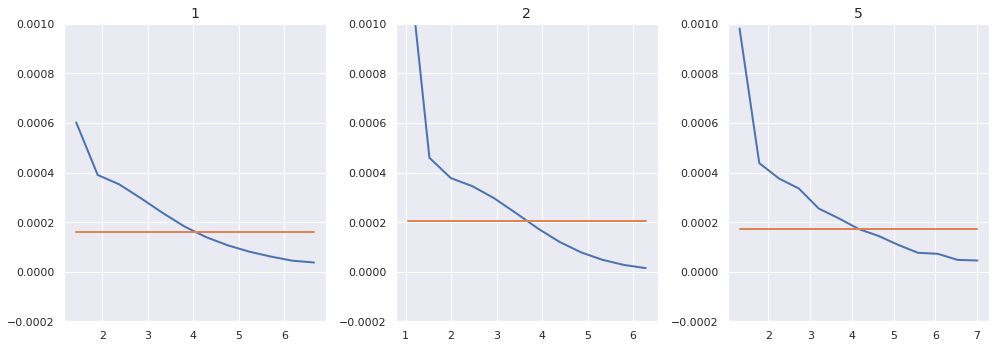

In [133]:
pad_ind_list = [1,2,5]
fig, axs = plt.subplots(1,3,figsize=(14,5))
for i, pad_ind in enumerate(pad_ind_list):
    ax = axs[i]
    y_vec, time_vec = est_lam(pad_ind)
    x_vec = time_vec
    ax.plot(x_vec/3600, y_vec)
    ax.plot(x_vec/3600, np.ones_like(x_vec)*np.median(y_vec))
    ax.set_title(np.int(pad_ind))
    ax.set_ylim([-0.0002,0.001])
fig.tight_layout()

In [37]:
import itertools

all_dfs = []
loop_var = itertools.product([True, False], [1,2,5])
ct_dict = {2:0,3:20,5:10}
chan_lambda = lambda x : ct_dict[x]
for diff, pad_ind in loop_var: 
    prefix = ['diff_',''][np.int(diff)]
    peak_out_fn = os.path.join(acq.super_dir, "csvs", '{}peaks_pad{}.csv').format(prefix, pad_ind)
    pad_fn = os.path.join(acq.super_dir, "csvs", '{}pad{}.csv').format(prefix, pad_ind)
    if os.path.exists(peak_out_fn):
        in_df = pd.read_csv(peak_out_fn)
        in_df['rad']=0
        lam, frame_vec = est_lam(pad_ind)
        bool_vec = np.array([xx in frame_vec for xx in in_df.frame.values])
        in_df['b_vec'] = bool_vec
        pad_df = pd.read_csv(pad_fn)
        rad_df = pad_df[['frame','channel','rad']].groupby(['frame','channel']).agg(np.min)
        in_gb = in_df.groupby(['frame','channel'])
        for key, sub_df in in_gb:
            if key in rad_df.index:
                in_df.loc[sub_df.index,'rad'] = rad_df.loc[key,'rad']
        radval = in_df.rad.quantile(0.75)
        y = (in_df.dist_binned + in_df.rad)/radval
        in_df['y'] = y
        tmp_bool = np.abs(y.values)>=1
        co = np.ones_like(y)
        ct = in_df.channel.apply(chan_lambda)
        inv_y = 1/y[tmp_bool]
        ind_t = in_df.loc[tmp_bool,'time']*lam
        co[tmp_bool] = np.arcsin(inv_y)*np.exp(ind_t)*radval
        in_df['co_ct'] = ct*(np.pi**2)*700 / (4*co)
        in_df.loc[False==tmp_bool,'co_ct'] = 0
        in_df['lam'] = lam
        in_df['radval'] = radval
        md_key = metadata_df.loc[pad_ind,'inducers']
#         in_df['mdi'] = md_key_dict[md_key]
        all_dfs.append(in_df)
peaks_df = pd.concat(all_dfs, ignore_index=True)
peaks_df['mdi'] = metadata_df.loc[peaks_df['pad'],'mdi'].values
peaks_df['l10_cct'] = np.log10(peaks_df['co_ct'].values)
fn = os.path.join(acq.super_dir,'csvs','peaks_df.csv')
peaks_df.to_csv(fn)

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


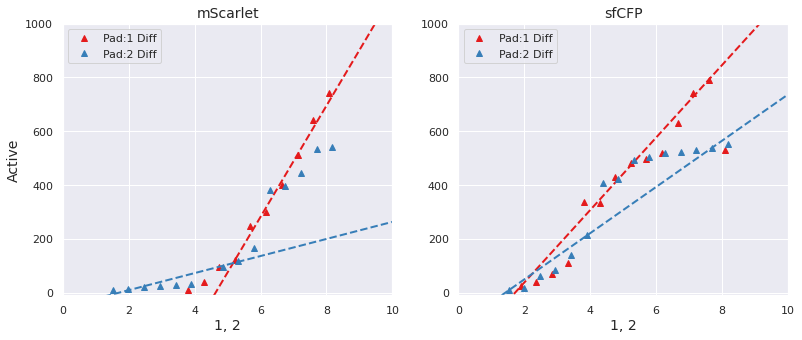

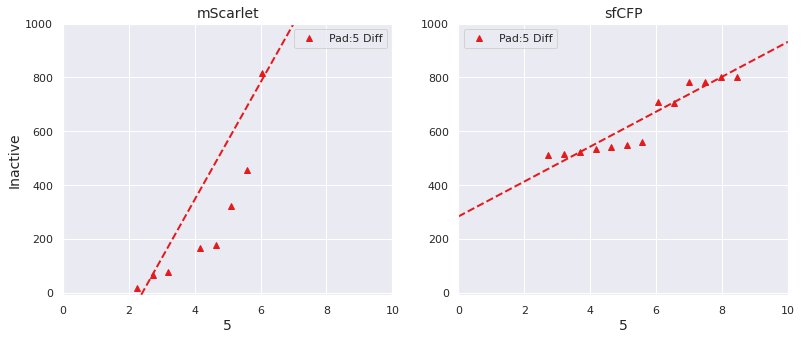

In [104]:
def fn(p, t):
    m, b = p
    return t*m + b

def res(p, t, y):
    yvec = fn(p, t)
    return np.sum(np.log(np.power(y-yvec,2)/50+1))


# Drop leftover artifacts
sub_peaks_df = peaks_df.copy()
drop_bool = (sub_peaks_df.dist_binned/1e3) > 0.6
drop_bool = drop_bool & ((sub_peaks_df.time/3600) < 5.8)
drop_inds = sub_peaks_df.index[drop_bool]
sub_peaks_df.drop(drop_inds, inplace=True)

bool_vec = (sub_peaks_df.level>=0)&(sub_peaks_df.level<10)&(sub_peaks_df.frame<18)
bool_vec = bool_vec&(sub_peaks_df.channel>2)&(sub_peaks_df['diff'])
gb_pad = sub_peaks_df.loc[bool_vec,:].groupby('pad')
metadata_gb = metadata_df.groupby('mdi')
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel','diff'])
            for sub_key, plot_df in sub_gb_cd:
                if len(plot_df)<1:
                    plt.close(fig)
                    continue
                chan, diff = sub_key
                ax_i = np.int(chan//4)
                plot_df = plot_df[['dist_binned','frame','time','rad','lam','y']].groupby('frame').agg(np.max).reset_index()
                y = plot_df.dist_binned
                m = ['o','^'][np.int(diff)]
                tvec = plot_df.time/3600
                res_lam = lambda p : res(p, tvec, y)
                afit = opt.minimize(res_lam, (1e-1,-1e4))
                tsim = np.linspace(0,10,50)
                ysim = fn(afit.x, tsim)
                dstr = ['',' Diff'][np.int(diff)]
                label = "Pad:{}{}".format(ind, dstr)
                if len(y)>0:
                    axs[ax_i].plot(tvec, y, m, label=label, c=c_dict[ind])
                    axs[ax_i].plot(tsim, ysim, '--', c=c_dict[ind])
        else:
            plt.close(fig)
    axs[0].set_ylabel(sub_df['label'].values[0])
    for ax_i, ax in enumerate(axs):
        ax.set_title(['mScarlet','sfCFP'][ax_i])
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
#         ax.set_xlim([1e4,5e4])
        ax.set_xlim([0,10])
        ax.set_ylim([-1e1,1e3])
        ax.legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


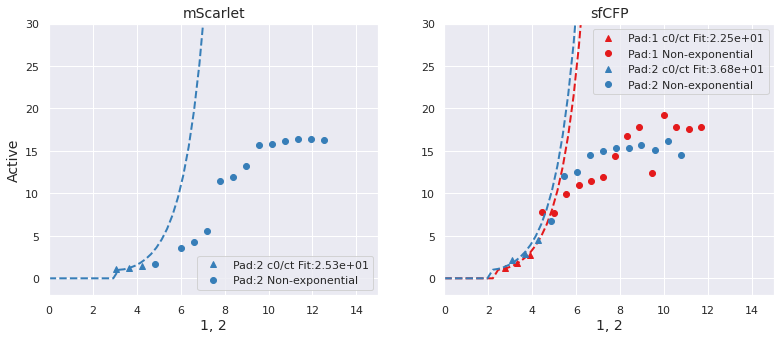

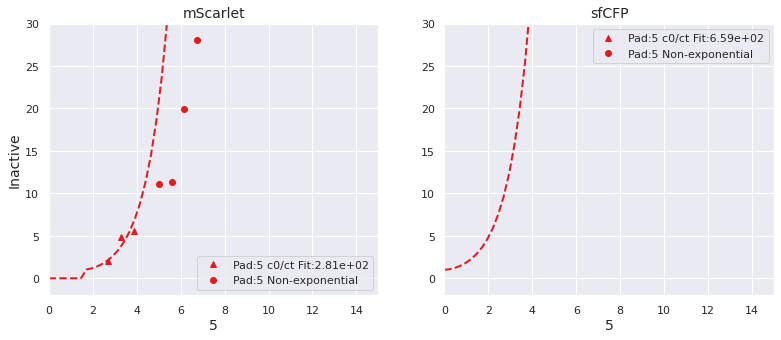

In [93]:

def fn(p, t, radval):
    c0, ct = p
    argument = np.exp(-t)/(radval*c0*4/(ct*700*np.pi**2))
    yvec=1/np.sin(argument)
    yvec[argument<0] = 0
    yvec[argument>np.pi/2] = 0
    return yvec

def res(p, t, y, radval):
    yvec = fn(p, t, radval)
    return np.sum(np.log(np.power(y-yvec,2)/100+1))

def fn2(p, y, radval):
    c0, ct = p
    y[y<=0] = 1e-4
    argument = np.arcsin(1/y)
    t = -np.log(argument*radval*c0*4/(ct*700*(np.pi**2)))
    t[y<0] = 0
    t[np.isnan(t)] = 0
    return t

def res2(p, t, y, radval):
    c0, ct = p
    if c0 <= 0:
        return np.inf
    tvec = fn2(p, y, radval)
    return np.sum(np.log(np.power(t-tvec,2)/10+1))

sub_peaks_df = peaks_df.copy()

# Drop leftover artifacts
drop_bool = (sub_peaks_df.dist_binned/1e3) > 0.6
drop_bool = drop_bool & ((sub_peaks_df.time/3600) < 5.8)
drop_inds = sub_peaks_df.index[drop_bool]
sub_peaks_df.drop(drop_inds, inplace=True)

bool_vec = (sub_peaks_df.frame>-1)&(sub_peaks_df.frame<25)
bool_vec = bool_vec&(sub_peaks_df.channel>2)&(sub_peaks_df['diff']==True)
bool_vec = bool_vec&(sub_peaks_df.y>1)
gb_pad = sub_peaks_df.loc[bool_vec,:].groupby('pad')
metadata_gb = metadata_df.groupby('mdi')

ct_dict = {3:20,5:10}
fit_df = []
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel','diff'])
            for sub_key, plot_df in sub_gb_cd:
                neg_df = plot_df.loc[False==plot_df.b_vec,:]   
                neg_df = neg_df[['dist_binned','frame','time','rad','lam','y']].groupby('frame').agg(np.max).reset_index()
                plot_df = plot_df.loc[plot_df.b_vec,:]    
                if len(plot_df) < 1:
                    continue
                radval = plot_df.radval.values[0]
                plot_df = plot_df[['dist_binned','frame','time','rad','lam','y']].groupby('frame').agg(np.max).reset_index()
                chan, diff = sub_key
                lam = plot_df.lam.mean()
                ct = ct_dict[chan]
                ax_i = np.int(chan//4)
                y = plot_df.y.values
                m = ['o','^'][np.int(diff)]
                tvec = plot_df.time.values*plot_df.lam.values
                res_c0 = lambda p : res2([p, ct], tvec, y, radval)
                afit = opt.minimize(res_c0, 1)
                tsim = np.linspace(0,12,50)
                ysim = fn([afit.x, ct], tsim, radval)
                dstr = ['',' c0/ct'][np.int(diff)]
                label = "Pad:{}{} Fit:{:02.2e}".format(ind, dstr, afit.x[0])
                if len(y)>0:
                    axs[ax_i].plot(tvec, y, m, label=label, c=c_dict[ind])
                    axs[ax_i].plot(tsim, ysim, '--', c=c_dict[ind])
                    fit_df.append((ind, chan, afit.x[0]))
                y = neg_df.y.values
                m = 'o'
                tvec = neg_df.time.values*neg_df.lam.values
                label = "Pad:{}{}".format(ind, ' Non-exponential')
                axs[ax_i].plot(tvec, y, m, label=label, c=c_dict[ind])
        else:
            plt.close(fig)
    axs[0].set_ylabel(sub_df['label'].values[0])
    for ax_i, ax in enumerate(axs):
        ax.set_title(['mScarlet','sfCFP'][ax_i])
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
        ax.set_xlim([0,15])
        ax.set_ylim([-2,30])
        ax.legend()
fit_df = pd.DataFrame(fit_df, columns=['pad','channel','c0'])

In [77]:
sub_peaks_gb = sub_peaks_df.groupby(['frame','channel','pad'])
out_df = []
for key, sub_df in sub_peaks_gb:
    sub_df = sub_df.sort_values(by='dist_binned')
    out_df.append(sub_df.iloc[:1,:])
out_df = pd.concat(out_df, ignore_index=True)

In [78]:
plt.figure(figsize=(6,4))

# Slim down to the data you want to show
plot_df = out_df.copy()
drop_bool = (plot_df.channel==5)&(plot_df['pad']==5)
plot_df.drop(plot_df.index[drop_bool],inplace=True)
# plot_df = sub_peaks_df.loc[sub_peaks_df.channel>2,:].copy()
# plot_df = plot_df.loc[plot_df['diff']==True,:]
# plot_df = plot_df.loc[plot_df['frame']<65,:]
# plot_df = plot_df.loc[plot_df['level']<1,:]
# plot_df = plot_df.loc[plot_df.b_vec,:]
# plot_df = plot_df.loc[bool_vec,:]
# plot_df = plot_df[['dist_binned','frame','time','rad','lam','y']].groupby('frame').agg(np.max).reset_index()

pad_lists = [metadata_gb.get_group(key).index.values for key in gb_keys]
pad_list = np.concatenate(pad_lists)
bool_vec = np.any([plot_df['pad']==xx for xx in pad_list],axis=0)
plot_df = plot_df.loc[bool_vec,:]
# plot_df = plot_df.loc[plot_df.plot_bool.values,:]

# Add columns to make plotting easier
conv_channel = lambda x : dict(zip([3.0,5.0],['mScarlet','sfCFP']))[x]
plot_df['Channel'] = plot_df.channel.apply(conv_channel)
color_dict = dict(zip(mma.all_channel_names, mma.mpl_named_colors))
conv_mdi = lambda x : mdi_dict[x]
plot_df['mdl'] = plot_df.mdi.apply(conv_mdi)

md_label_df = plot_df[['mdl','mdi']].groupby('mdi').agg(np.min).reset_index()
md_label_df['mdx'] = np.arange(len(md_label_df))
mdx_dict = dict(zip(md_label_df.mdi.values, md_label_df.mdx.values))
chan_dx_dict = {3:-0.25,5:0.25}

fdf_gb = fit_df.groupby('pad')
fit_df['mdi']=-1
fit_df['mdx']=-1
for key, sub_df in fdf_gb:
    md_key = metadata_df.loc[key,'inducers']
    fit_df.loc[sub_df.index,'mdi'] = md_key_dict[md_key]
fdf_gb = fit_df.groupby(['mdi','channel'])
for key, sub_df in fdf_gb:
    mdi, channel = key
    if mdi in md_label_df['mdi'].values:
        fit_df.loc[sub_df.index,'mdx'] = mdx_dict[mdi]+chan_dx_dict[channel]

# sns.boxplot(data=plot_df, x='mdl',y='l10_co',hue='Channel', dodge=True, palette=color_dict)
sns.swarmplot(data=plot_df, x='mdl',y='l10_cct',hue='Channel', dodge=True, palette=color_dict)
mdlabels = list(metadata_gb.groups.keys())
# _ = plt.xticks(np.arange(len(mdlabels)), mdlabels,rotation=30)
# _ = plt.xticks(np.arange(2), ['Active', 'Inactive'],rotation=30)
_ = plt.xlabel('Amplifier condition')
_ = plt.ylabel('Sender synthesis rate\n(molecules / (s $\mu$m$^2$))')
plt.tight_layout()

drop_inds = fit_df.index[(fit_df['pad']==5)&(fit_df['channel']==5)]
plot_fit_df = fit_df.drop(drop_inds, inplace=False)
plt.plot(plot_fit_df.mdx, np.log10(plot_fit_df.c0), 'kX',zorder=20,ms=12)
plt.plot(plot_fit_df.mdx, np.log10(plot_fit_df.c0), 'wx',zorder=21,ms=8)

NameError: name 'gb_keys' is not defined

<Figure size 432x288 with 0 Axes>

In [199]:
import itertools
all_dfs = []
loop_var = itertools.product([True, False], [1,2,5])
for diff, pad_ind in loop_var: 
    inducers = metadata_df.loc[pad_ind,'inducers']
    prefix = ['diff_',''][np.int(diff)]
    peak_out_fn = os.path.join(acq.super_dir, "csvs", '{}peaks_pad{}.csv').format(prefix, pad_ind)
    pad_fn = os.path.join(acq.super_dir, "csvs", '{}pad{}.csv').format(prefix, pad_ind)
    if os.path.exists(peak_out_fn):
        in_df = pd.read_csv(peak_out_fn)
        in_df['rad']=0
        pad_df = pd.read_csv(pad_fn)
        in_df['inducers'] = inducers
        rad_df = pad_df[['frame','channel','rad']].groupby(['frame','channel']).agg(np.min)
        in_gb = in_df.groupby(['frame','channel'])
        for key, sub_df in in_gb:
            if key in rad_df.index:
                in_df.loc[sub_df.index,'rad'] = rad_df.loc[key,'rad']
        all_dfs.append(in_df)
peaks_df = pd.concat(all_dfs, ignore_index=True)

In [154]:
gb_lcp = peaks_df.groupby(['level','channel','pad'])
min_rows = []
for key, sub_df in gb_lcp:
    sub_df = sub_df.sort_values(by='dist_binned').reset_index()
    min_rows.append(sub_df.iloc[[0],:])
mins_df = pd.concat(min_rows,ignore_index=True)

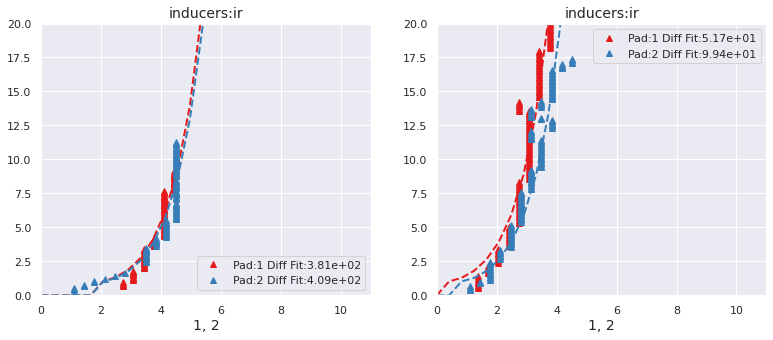

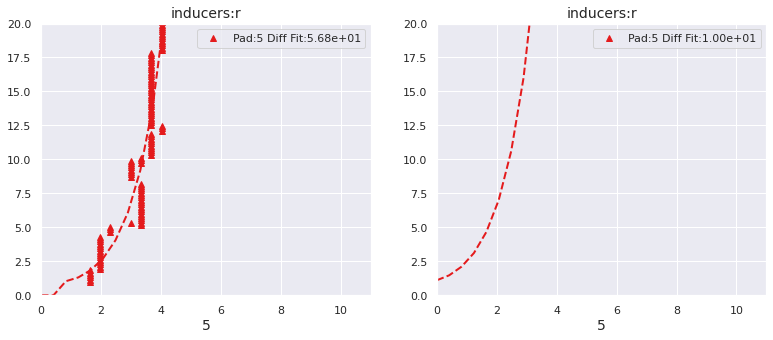

In [178]:
def fn(p, t, radval):
    argument = p*np.exp(-t)/radval
    yvec=1/np.sin(argument)
    yvec[argument<0] = 0
    yvec[argument>np.pi/2] = 0
    return yvec

def res(p, t, y, radval):
    yvec = fn(p, t, radval)
    return np.sum(np.log(np.power(y-yvec,2)/100+1))

bool_vec = (peaks_df.level<1)&(peaks_df.frame<14)
bool_vec = bool_vec&(peaks_df.frame>1)&(peaks_df.channel>2)&(peaks_df['diff']==True)
gb_pad = peaks_df.loc[bool_vec,:].groupby('pad')
metadata_gb = metadata_df.loc[metadata_df.skip==False,:].groupby('inducers')
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel','diff'])
            for sub_key, plot_df in sub_gb_cd:
                chan, diff = sub_key
#                 lam, frame_vec = est_lam(ind)
                lam = 2e-4
#                 bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
#                 plot_df = plot_df.loc[bool_vec,:]
                ax_i = np.int(chan//4)
                radval = plot_df.rad.quantile(0.5)
                y = (plot_df.dist_binned + plot_df.rad)/radval
                bool_vec = y < 20
#                 y = (plot_df.dist_binned + radval)/radval
                m = ['o','^'][np.int(diff)]
                tvec = plot_df.time*lam
                res_lam = lambda p : res(p, tvec[bool_vec], y[bool_vec], radval)
                afit = opt.minimize(res_lam, 10)
                tsim = np.linspace(0,12,30)
                ysim = fn(afit.x, tsim, radval)
                dstr = ['',' Diff'][np.int(diff)]
                label = "Pad:{}{} Fit:{:02.2e}".format(ind, dstr, afit.x[0])
                if len(y)>0:
                    axs[ax_i].plot(tvec, y, m, label=label, c=c_dict[ind])
                    axs[ax_i].plot(tsim, ysim, '--', c=c_dict[ind])
    for ax in axs:
        title_tmpl = 'inducers:{}'
        title_vals = [str(xx) for xx in sub_df[['inducers']].values[0,:]]
        ax.set_title(title_tmpl.format(*title_vals))
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
        ax.set_xlim([0,11])
        ax.set_ylim([0,20])
        ax.legend()

Text(0, 0.5, 'Distance (mm)')

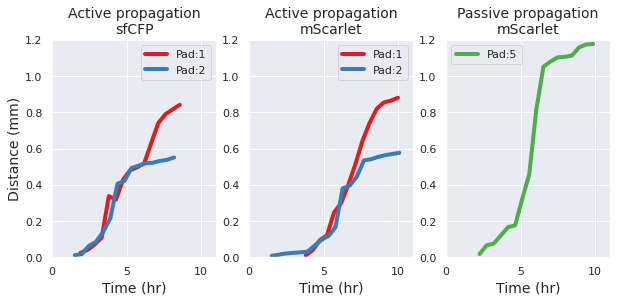

In [255]:
bool_vec = (peaks_df.level<1)&(peaks_df.channel>2)&(peaks_df['diff']==True)
sub_peaks_df = peaks_df.loc[bool_vec,:].copy()

# Drop leftover artifacts
drop_bool = (sub_peaks_df.dist_binned/1e3) > 0.6
drop_bool = drop_bool & ((sub_peaks_df.time/3600) < 5.8)
drop_inds = sub_peaks_df.index[drop_bool]
sub_peaks_df.drop(drop_inds, inplace=True)

gb_pad_channel = sub_peaks_df.groupby(['pad','channel','diff'])
fig, axs = plt.subplots(1,3,figsize=(10,4))
plot_gb = sub_peaks_df.groupby(['inducers','channel'])
pad_list = np.unique(sub_peaks_df['pad'].values)
n_pads = len(pad_list)
if n_pads >= 1:
    c_vec = list(plt.cm.Set1.colors)
    c_dict = dict(zip(pad_list, c_vec))
# for ind in sub_df.index.values:
ind_dict = dict(zip(['ir','r'],['Active propagation','Passive propagation']))
loop_keys = [('ir', 5.0), ('ir', 3.0), ('r', 3.0)]
for ind, key in enumerate(loop_keys):
    sub_df = plot_gb.get_group(key)
    inducers, channel = key
    ax = axs[ind]
    pads = np.unique(sub_df['pad'].values)
    for ind in pads:
        plot_df = gb_pad_channel.get_group((ind, channel,True))
        plot_df = plot_df[['dist_binned','frame','time','rad']].groupby('frame').agg(np.max).reset_index()
        y = plot_df.dist_binned/1e3
        m = ['o','^'][np.int(diff)]
        tvec = plot_df.time/3600
        dstr = ['',' Diff'][np.int(diff)]
        label = "Pad:{}{}".format(ind, dstr)
        if len(y)>0:
            ax.plot(tvec, y, lw=4,label=label, c=c_dict[ind])
    title_str = '\n'.join([ind_dict[inducers],mma.all_channel_names[int(channel)]])
    ax.set_title(title_str)
#     ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
    ax.set_xlabel('Time (hr)')
    ax.set_xlim([0,11])
    ax.set_ylim([0,1.2])
    ax.legend()
axs[0].set_ylabel('Distance (mm)')

Text(0, 0.5, 'n.d. Distance')

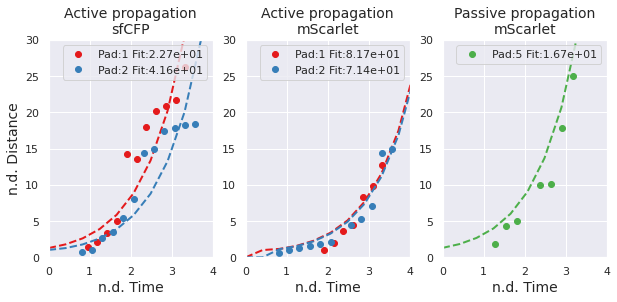

In [252]:
bool_vec = (peaks_df.level<1)&(peaks_df.channel>2)&(peaks_df['diff']==True)
sub_peaks_df = peaks_df.loc[bool_vec,:].copy()

# Drop leftover artifacts
drop_bool = (sub_peaks_df.dist_binned/1e3) > 0.6
drop_bool = drop_bool & ((sub_peaks_df.time/3600) < 5.8)
drop_inds = sub_peaks_df.index[drop_bool]
sub_peaks_df.drop(drop_inds, inplace=True)

gb_pad_channel = sub_peaks_df.groupby(['pad','channel','diff'])
fig, axs = plt.subplots(1,3,figsize=(10,4))
plot_gb = sub_peaks_df.groupby(['inducers','channel'])
pad_list = np.unique(sub_peaks_df['pad'].values)
n_pads = len(pad_list)
if n_pads >= 1:
    c_vec = list(plt.cm.Set1.colors)
    c_dict = dict(zip(pad_list, c_vec))
# for ind in sub_df.index.values:
ind_dict = dict(zip(['ir','r'],['Active propagation','Passive propagation']))
loop_keys = [('ir', 5.0), ('ir', 3.0), ('r', 3.0)]
for ind, key in enumerate(loop_keys):
    sub_df = plot_gb.get_group(key)
    inducers, channel = key
    ax = axs[ind]
    pads = np.unique(sub_df['pad'].values)
    for ind in pads:
        lam, frame_vec = est_lam(ind)
        plot_df = gb_pad_channel.get_group((ind, channel,True))
        bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
        plot_df = plot_df.loc[bool_vec,:]
        plot_df = plot_df[['dist_binned','frame','time','rad']].groupby('frame').agg(np.max).reset_index()
        radval = plot_df.rad.quantile(0.5)
        y = (plot_df.dist_binned + plot_df.rad)/radval
        m = ['o','^'][np.int(diff)]
        tvec = plot_df.time*lam
        res_lam = lambda p : res(p, tvec, y, radval)
        afit = opt.minimize(res_lam, 10)
        tsim = np.linspace(0,12,30)
        ysim = fn(afit.x, tsim, radval)
        dstr = ['',' Diff'][np.int(diff)]
        label = "Pad:{}{} Fit:{:02.2e}".format(ind, dstr, afit.x[0])
        if len(y)>0:
            ax.plot(tvec, y, m, label=label, c=c_dict[ind])
            ax.plot(tsim, ysim, '--', c=c_dict[ind])
    title_str = '\n'.join([ind_dict[inducers],mma.all_channel_names[int(channel)]])
    ax.set_title(title_str)
#     ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
    ax.set_xlabel('n.d. Time')
    ax.set_xlim([0,4])
    ax.set_ylim([0,30])
    ax.legend()
axs[0].set_ylabel('n.d. Distance')

/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


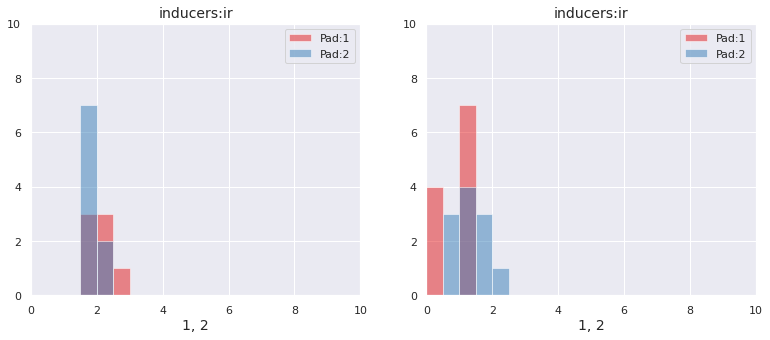

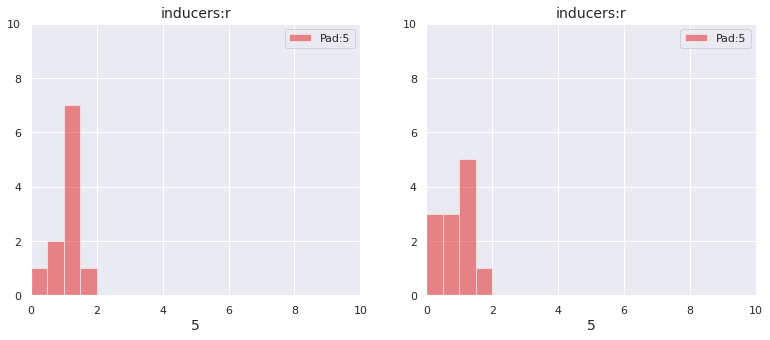

In [257]:
for key, sub_df in metadata_gb:
    fig, axs = plt.subplots(1,2,figsize=(13,5))
    pad_list = np.unique(sub_df.index.values)
    n_pads = len(pad_list)
    if n_pads >= 1:
        c_vec = list(plt.cm.Set1.colors)
        c_dict = dict(zip(pad_list, c_vec))
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel'])
            for key, plot_df in sub_gb_cd:
#                 chan, diff = key
                chan = key
#                 ax_i = np.int(key[0]//4)
                ax_i = np.int(key//4)
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                plot_df = plot_df[['dist_binned','frame','time','rad']].groupby('frame').agg(np.max).reset_index()
                radval = plot_df.rad.quantile(0.5)
                rri = (plot_df.dist_binned + plot_df.rad)/radval
                y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
                y = np.log10(y)
                if len(y)>0:
                    label = "Pad:{}{}".format(ind, ['',' Diff'][np.int(diff)])
                    _ = axs[ax_i].hist(y, label=label, color=c_dict[ind],alpha=0.5,bins=np.arange(0,10,0.5))
    for ax in axs:
        title_tmpl = 'inducers:{}'
        title_vals = [str(xx) for xx in sub_df[['inducers']].values[0,:]]
        ax.set_title(title_tmpl.format(*title_vals))
        ax.set_xlabel(', '.join([str(xx) for xx in sub_df.index.values]))
        ax.set_xlim([0,10])
        ax.set_ylim([0,10])
        ax.legend()

In [283]:
peaks_df['y'] = np.nan
peaks_df['mdi'] = np.nan
md_list = metadata_gb.agg(np.min).index.values
ax_nw = len(metadata_gb)
skipped_pads_list = []
for md_i, loopvar in enumerate(metadata_gb):
    key, sub_df = loopvar
    skipped_pads = []
    for ind in sub_df.index.values:
        if ind in gb_pad.groups.keys():
            sub_pad_df = gb_pad.get_group(ind)
            sub_gb_cd = sub_pad_df.groupby(['channel'])
            for key, plot_df in sub_gb_cd:
                lam, frame_vec = est_lam(ind)
                bool_vec = np.array([xx in frame_vec for xx in plot_df.frame.values])
                plot_df = plot_df.loc[bool_vec,:]
                if np.any(bool_vec):
                    radval = plot_df.rad.quantile(0.5)
                    rri = (plot_df.dist_binned + plot_df.rad)/radval
                    y = np.arcsin(1/rri)*np.exp(plot_df.time*lam)*radval
                    y = np.log10(y*700*(np.pi**2)/4)
                    peaks_df.loc[plot_df.index, 'y'] = y
                    peaks_df.loc[plot_df.index, 'mdi'] = md_i
                else:
                    skipped_pads.append(ind)
        else:
            skipped_pads.append(ind)
    skipped_pads_list.append(skipped_pads)

peaks_gb_md = peaks_df.groupby(['mdi','channel'])
keys = list(peaks_gb_md.groups.keys())
key_ind_dict = dict(zip(keys, np.arange(len(keys))))


/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jparkin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


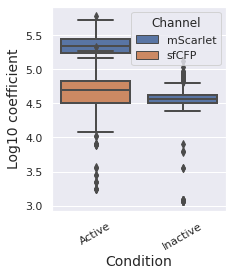

In [284]:
plt.figure(figsize=(3.4,4))
plot_df = peaks_df.loc[peaks_df.channel>2,:].copy()
plot_df = plot_df.loc[plot_df['diff']==True,:]
plot_df.drop(plot_df.index.values[(plot_df['channel']==5)&(plot_df['pad']==5)], inplace=True, axis=0)
plot_df.drop(plot_df.index.values[(plot_df['y']<1.5)], inplace=True, axis=0)
# plot_df = plot_df[['dist_binned','frame','time','rad']].groupby('frame').agg(np.max).reset_index()
conv_channel = lambda x : dict(zip([3.0,5.0],['mScarlet','sfCFP']))[x]
plot_df['Channel'] = plot_df.channel.apply(conv_channel)
sns.boxplot(data=plot_df, x='mdi',y='y',hue='Channel', dodge=False)
mdlabels = list(metadata_gb.groups.keys())
# _ = plt.xticks(np.arange(2), mdlabels,rotation=30)
_ = plt.xticks(np.arange(2), ['Active', 'Inactive'],rotation=30)
_ = plt.xlabel('Condition')
_ = plt.ylabel('Log10 coefficient')
plt.tight_layout()

In [269]:
np.sum(np.isnan(plot_df.y))

18706